# **Mapping an Unknown local using SLAM**

### **Overview**
This project focuses on implementing and testing a Simultaneous Localization and Mapping (SLAM) system for a robot equipped with a LIDAR. The goal is to enable the robot to explore and map an unknown environment while estimating its own pose in real-time.


### **Project Authors**

- **up202004966 - Bruno Filipe Torres Costa**
- **up201906003 - Pedro Miguel Oliveira Rodrigues**

# **Loading Data**

### **LIDAR**:
*  Range measurements across 61 angles
*  Angles span from -30 to 30 with 1 deg step, centered on the robot's forward axis

### **Data Format**

*  First three columns: Noisy odometry data (Δx,Δy,Δθ).
*  Last 61 columns: LIDAR distance measurements for each angle.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data file
file_path = '/content/data_slam_tab.txt'
# Read the data into a DataFrame
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Assign column names based on the description in the task
column_names = ['delta_x', 'delta_y', 'delta_theta'] + [f'lidar_{i}' for i in range(1, 62)]
data.columns = column_names

# Inspect the data structure (first few rows)
data.head(10)

<ipython-input-354-f87bf6898071>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


,delta_x,delta_y,delta_theta,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,lidar_6,lidar_7,...,lidar_52,lidar_53,lidar_54,lidar_55,lidar_56,lidar_57,lidar_58,lidar_59,lidar_60,lidar_61
0,0.091261,0.619679,-0.034699,2.223204,2.185114,2.169361,2.140068,2.143558,2.119054,2.103991,...,2.070020,2.083667,2.080040,2.104789,2.125904,2.137601,2.148020,2.140984,2.054932,1.993838
1,0.074645,0.624864,-0.027507,1.559413,1.536321,1.545295,1.514572,1.505003,1.504811,1.467239,...,1.445828,1.458326,1.479705,1.468454,1.491747,1.479468,1.496957,1.522511,1.548444,1.556354
2,-0.041652,0.711618,-0.013012,0.884545,0.876014,0.872565,0.860574,0.867471,0.859891,0.849244,...,0.809680,0.825866,0.831438,0.844005,0.852132,0.862546,0.850723,0.867609,0.872114,0.881175
3,-0.047177,0.216664,-0.123891,0.628522,0.639786,0.613950,0.620505,0.612565,0.620891,0.602311,...,0.503525,0.521727,0.505995,0.523298,0.521310,0.506648,0.527754,0.536555,0.516389,0.534519
4,0.110510,-0.111119,-0.270819,0.899172,0.866510,0.848103,0.828301,0.812181,0.807989,0.767401,...,0.490357,0.503178,0.503634,0.492645,0.506921,0.502065,0.484845,0.508082,0.526686,0.501545
5,-0.024347,-0.089328,-0.252840,1.652401,1.570170,1.502908,1.433933,1.345861,1.296466,1.271968,...,0.522189,0.517631,0.525584,0.528638,0.499807,0.506118,0.536014,0.529955,0.510757,0.511723
6,0.015634,0.043920,-0.266153,2.005009,1.991576,2.012526,2.014365,2.014785,1.989758,2.021117,...,0.646783,0.628025,0.610454,0.614022,0.602025,0.596596,0.598578,0.573599,0.566537,0.575663
7,0.092706,0.013834,-0.282485,2.091659,2.058054,2.056313,2.053564,2.044647,2.030234,2.036294,...,0.881312,0.850130,0.842630,0.816255,0.809353,0.770661,0.732871,0.747066,0.727572,0.717897
8,0.093303,0.022372,-0.243344,2.207322,2.197465,2.148043,2.137095,2.123620,2.106412,2.086457,...,1.382167,1.333429,1.275733,1.234053,1.187342,1.117813,1.100745,1.065256,1.026042,1.004751
9,0.473074,0.017879,0.006176,1.596833,1.556025,1.564584,1.521824,1.520679,1.493695,1.484348,...,1.392917,1.333412,1.267842,1.227432,1.180350,1.143470,1.101378,1.049597,1.035893,1.019744


# **Data Analysis**

## **Lidar Snapshot in Local Robot Frame**

Converting Lidar snapshot data from polar coordinates to cartesian coordinates in robot local frame.

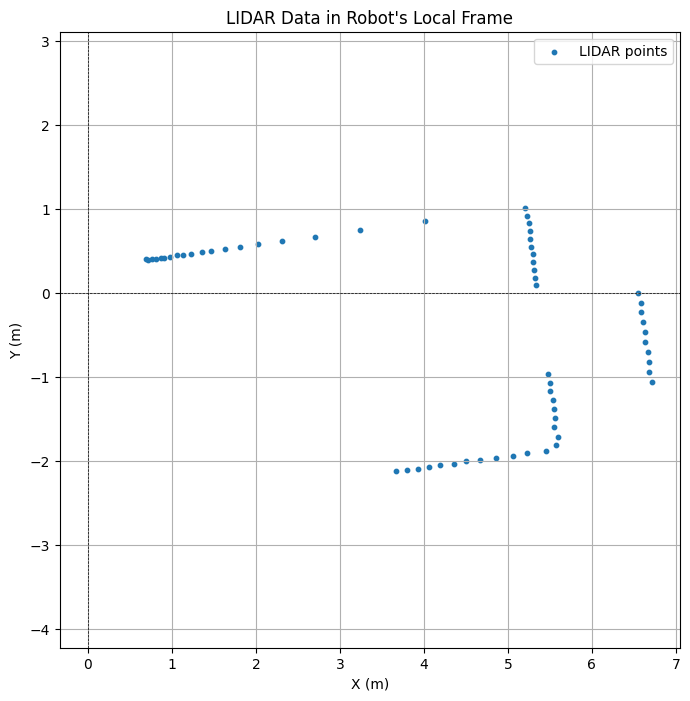

In [ ]:
# Function to transform LIDAR measurements to Cartesian coordinates relative to the robot
def lidar_to_cartesian(lidar_data, angles):
    x_cartesian = lidar_data * np.cos(angles)
    y_cartesian = lidar_data * np.sin(angles)
    return x_cartesian, y_cartesian

# Extract a single LIDAR snapshot for demonstration
idx = 123

# Constants for LIDAR
lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

# Lidar frame data
lidar_snapshot = data.loc[idx, 'lidar_1':'lidar_61'].to_numpy()

# Transform to Cartesian coordinates
x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

# Visualize the LIDAR data in the robot's local frame
plt.figure(figsize=(8, 8))
plt.scatter(x_local, y_local, s=10, label="LIDAR points")
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.title("LIDAR Data in Robot's Local Frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

## **Local to global frame**

Converting LIDAR data from local robot frame to global frame.

In [ ]:
# Function to transform local coordinates to global coordinates
def transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta):
    """Transform points from robot's local frame to global frame."""
    # Create rotation matrix
    R = np.array([[np.cos(robot_theta), -np.sin(robot_theta)],
                  [np.sin(robot_theta), np.cos(robot_theta)]])

    # Stack points for vectorized transformation
    local_points = np.vstack((local_x, local_y))

    # Apply rotation and translation
    global_points = R @ local_points
    global_x = global_points[0, :] + robot_x
    global_y = global_points[1, :] + robot_y

    return global_x, global_y

## **Control Signal Analysis**

The control signals $\Delta$x, $\Delta$y, and $\Delta$Θ represent the incremental displacements of the robot between each movement step. These signals are essential for estimating the robot's pose and constructing a map of the environment in the SLAM process.

### Definitions:
- $\Delta$x: Displacement along the x axis of the global frame.
- $\Delta$y: Displacement along the y axis of the global frame.
- $\Delta$Θ: Change in orientation or heading angle (in radians) in the global frame.

### Role in the SLAM System:
1. **Pose Estimation:**
   - The control signals are combined with the robot's previous pose to compute an initial estimate of the new pose at each time step.
   
2. **Odometry-Based Localization:**
   - These signals provide an incremental approximation of the robot's trajectory, which serves as the baseline for further refinement through sensor fusion.

3. **Integration with LIDAR:**
   - $\Delta$x, $\Delta$y, and $\Delta$Θ: are used alongside LIDAR measurements to identify and localize environmental features, such as corners and walls.

### Challenges:
1. **Sensor Noise:**
   - The odometry data used to calculate the control signals is noisy, leading to inaccuracies in pose estimation and drift over time.

2. **Cumulative Errors:**
   - Small errors in each step accumulate, causing significant deviations in the robot's estimated pose.

3. **Non-Linear Motion:**
   - Rotational $\Delta$Θ and translational $\Delta$x, $\Delta$y movements introduce non-linearity, requiring robust mathematical models to predict the robot's motion.

Text(0.5, 1.0, 'Absolute values of delta_x and delta_y')

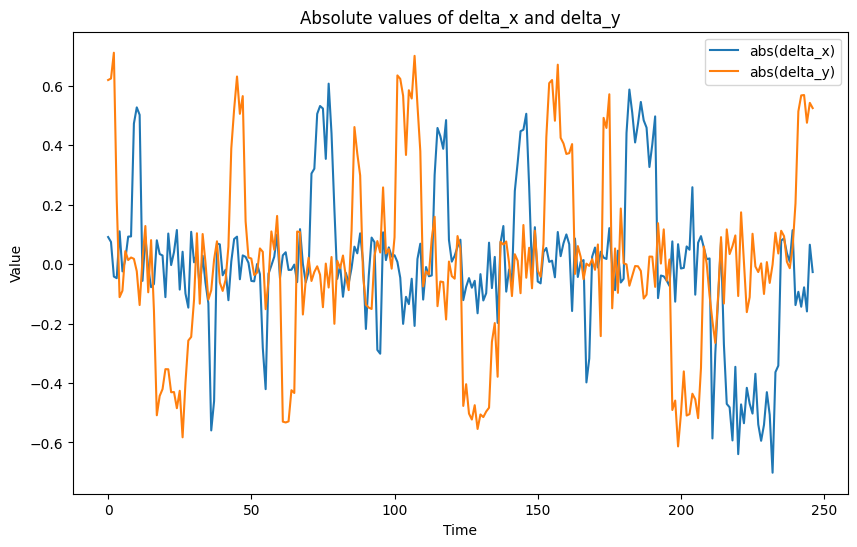

In [ ]:
from scipy.ndimage import gaussian_filter1d

# plot the abs(delta_x) and abs(delta_y) values
plt.figure(figsize=(10, 6))
plt.plot(data['delta_x'], label='abs(delta_x)')
plt.plot(data['delta_y'], label='abs(delta_y)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Absolute values of delta_x and delta_y')

The observed max displacement of almost 60 cm per step introduces substantial error into the pose estimation model. This large movement amplifies the effects of odometry noise and increases uncertainty in the robot's position.

Text(0.5, 1.0, 'Absolute values of delta_theta in degrees')

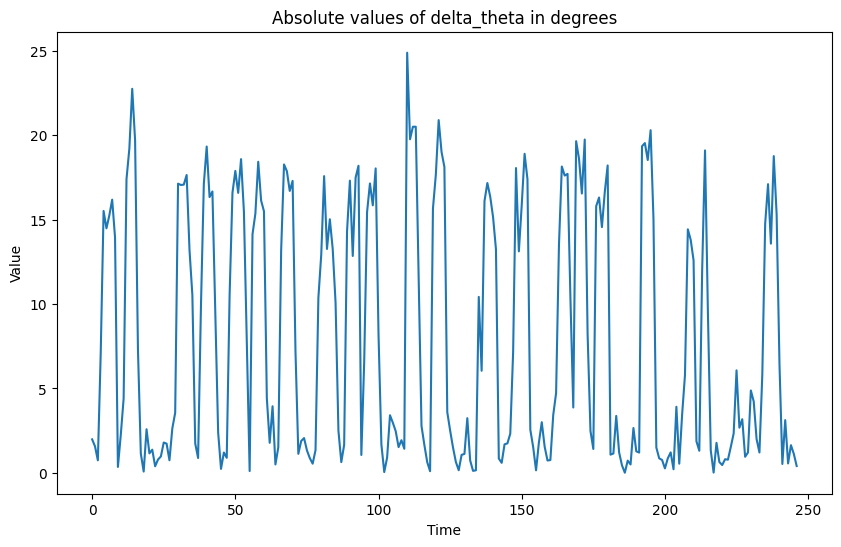

In [ ]:
# plot the abs(delta_theta) values in degrees
plt.figure(figsize=(10, 6))
plt.plot(np.abs(data['delta_theta']) * 180 / np.pi)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Absolute values of delta_theta in degrees')

The observed max displacement of almost 25 degrees per step introduces substantial error into the pose estimation model. This large movement amplifies the effects of odometry noise and increases uncertainty in the robot's position.

## **Estimating Robot Trajectory with Odometry**

To estimate the robot's trajectory using odometry, a simple motion model is employed. The model assumes incremental updates to the robot's pose $(x, y, \theta)$ based on the odometry data $(\Delta x, \Delta y, \Delta \theta)$.

### Motion Model:
The robot's pose is updated at each step as follows:

1. **Position in $x$:**

  $x_{new}$ = $x_{prev}$ + Δ$x$

2. **Position in $y$:**

  $y_{new}$ = $y_{prev}$ + Δ$y$

3. **Orientation ($\theta$):**

  $\theta_{new}$ = $\theta_{prev}$ + Δ$\theta$

### Explanation:
- $\Delta x$: Displacement along the $x$-axis.
- $\Delta y$: Displacement along the $y$-axis.
- $\Delta \theta$: Change in the robot's orientation (heading angle).

### Assumptions:
- The motion model assumes a differential drive robot or a similar platform where the control signals are directly applied to update the pose.
- $\Delta x, \Delta y, \Delta \theta$ are derived from noisy odometry readings, so the pose estimates are prone to drift.

### Challenges:
1. **Cumulative Errors:**
   - Small inaccuracies in odometry readings compound over time, leading to significant deviations in the estimated trajectory.
2. **Noise in Measurements:**
   - Sensor noise affects the precision of $\Delta x, \Delta y, \Delta \theta$, reducing the reliability of pose estimates.
3. **Non-linear Trajectories:**
   - When $\Delta \theta$ is significant, the model needs to account for rotational motion to avoid large pose errors.

### Improvements:
1. **Sensor Fusion:**
   - Integrate odometry with external sensors (e.g., LIDAR or IMU) to correct pose drift using methods like an **Extended Kalman Filter (EKF)**.
2. **Angle Normalization:**
   - Normalize $\theta$ to the range $[- \pi, \pi]$ after each update to maintain consistency in orientation.

### Conclusion:
This motion model provides a straightforward way to estimate the robot's trajectory using odometry. However, its reliance on noisy data necessitates the use of sensor fusion and smoothing techniques to improve accuracy and robustness in real-world scenarios.

In [ ]:
def robot_odometry(pos, U):
    """
    Updates the robot's position based on the control inputs (U).
    pos: Current position [x, y, theta]
    U: List or array of updates [[dx1, dy1, dtheta1], [dx2, dy2, dtheta2], ...]
    """
    U = U.reshape(3, 1)
    pos[0] += U[0]
    pos[1] += U[1]
    pos[2] += U[2]
    pos[2] = pos[2] % (2 * np.pi)
    return pos

def estimated_odo_pos(data, idx):
    """
    Estimates the robot's final position after applying multiple updates.
    data: Initial position dictionary {"x": x, "y": y, "theta": theta}
    U: Array of updates [[dx1, dy1, dtheta1], [dx2, dy2, dtheta2], ...]
    """
    pos = np.array([0.0, 0.0, 1.57]).reshape(3, 1)
    U = data.loc[:, ['delta_x', 'delta_y', 'delta_theta']].to_numpy()
    for i in range(idx):
        pos = robot_odometry(pos, U[i])
    return pos

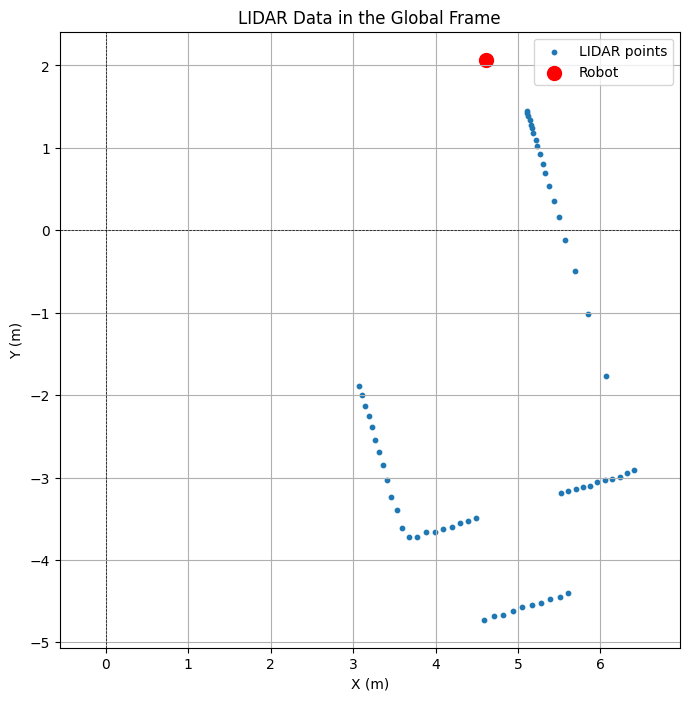

In [ ]:
# Constants for LIDAR
lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

# Extract a single LIDAR snapshot for demonstration
idx = 123
lidar_snapshot = data.loc[idx, 'lidar_1':'lidar_61'].to_numpy()

# Transform to Cartesian coordinates
x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

# Estimate robot positon
pos = estimated_odo_pos(data, idx)

# Transform to global coordinates
x_global, y_global = transform_to_global(x_local, y_local, pos[0][0], pos[1][0], pos[2][0])

# Visualize the LIDAR data in the robot's local frame
plt.figure(figsize=(8, 8))
plt.scatter(x_global, y_global, s=10, label="LIDAR points")
plt.scatter(pos[0], pos[1], s=100, label="Robot", color="red")
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.title("LIDAR Data in the Global Frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()
plt.close()

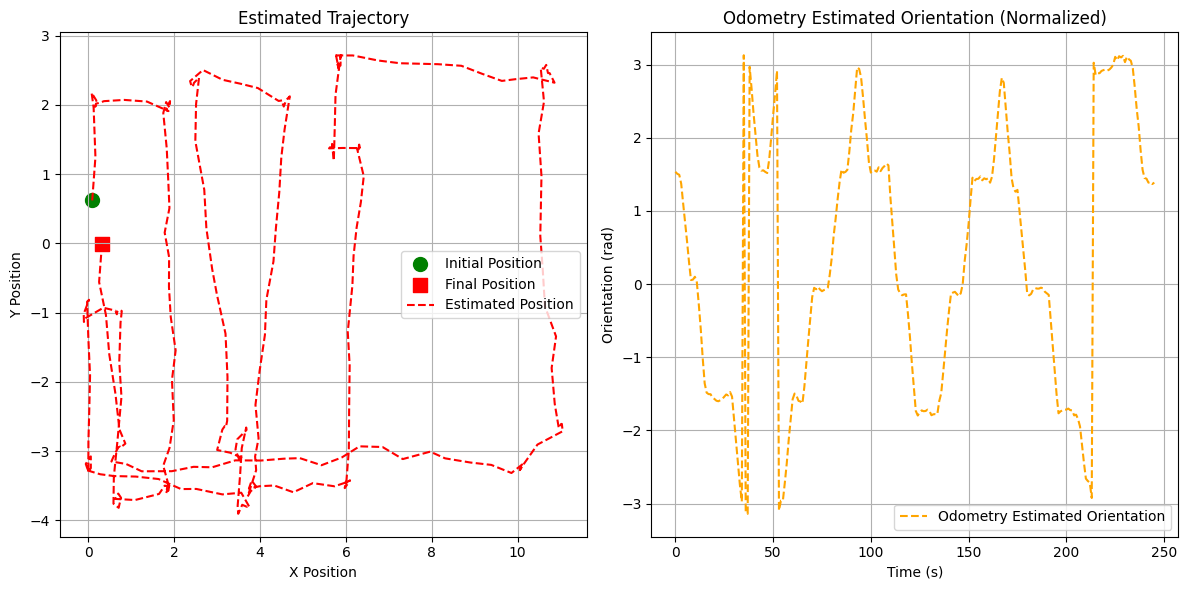

In [ ]:
# Function to normalize theta within [-pi, pi]
def normalize_angle(theta):
    return (theta + np.pi) % (2 * np.pi) - np.pi

# Dead reckoning loop
estimated_pos = []  # Store estimated positions
theta_est_normalized = []  # Store normalized orientation angles

for i in range(1, len(data)):
    # Compute new estimates
    robot_pos = estimated_odo_pos(data, i)
    # Normalize theta
    robot_pos[2] = normalize_angle(robot_pos[2])

    # Append to the result lists
    estimated_pos.append(robot_pos)
    theta_est_normalized.append(robot_pos[2])

# Extract x, y, and theta components for plotting
x_est = [pos[0] for pos in estimated_pos]
y_est = [pos[1] for pos in estimated_pos]

# Plotting
plt.figure(figsize=(12, 6))

# True vs Estimated positions
plt.subplot(1, 2, 1)
plt.scatter(x_est[0], y_est[0], color='green', marker='o', s=100, label='Initial Position')  # Initial position
plt.scatter(x_est[-1], y_est[-1], color='red', marker='s', s=100, label='Final Position')  # Final position
plt.plot(x_est, y_est, label='Estimated Position', linestyle='--', color='red')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Estimated Trajectory')
plt.legend()
plt.grid(True)

# Orientation comparison with normalization
plt.subplot(1, 2, 2)
plt.plot(theta_est_normalized, label='Odometry Estimated Orientation', linestyle='--', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('Odometry Estimated Orientation (Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Corner-based SLAM**

Simultaneous Localization and Mapping (SLAM) is a critical technique for autonomous robots navigating unknown environments. This implementation focuses on leveraging **corners** (both convex and concave) detected from LIDAR measurements to enhance mapping accuracy and localization.

## Overview

### What are Corners in SLAM?
Corners are distinctive geometric features in an environment, such as the intersection of two walls, that provide robust landmarks for localization and mapping. They can be classified as:
- **Convex Corners**: Outward angles formed at wall intersections.
- **Concave Corners**: Inward angles at wall intersections.

### Why Corners?
- **High Distinctiveness**: Corners are unique features that are easy to detect and localize.
- **Reduced Ambiguity**: Using corners as landmarks minimizes the risk of matching errors compared to less distinctive features.
- **Improved Accuracy**: Localizing based on corners helps in refining the robot's pose and building a more accurate map.

## Conclusion
SLAM with corners provides a robust framework for mapping and localization in structured environments. By focusing on distinctive geometric features, this approach improves the accuracy and efficiency of SLAM, making it a preferred choice for robots operating in indoor environments with sharp edges and corners.

## **Task1**
### **Estimating Corners (Convex or Concave)**


### **Clustering Data**

Clustering LIDAR data using DBSCAN algorithm.

References: [DBSCAN algorithm](https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F-,Density%2Dbased%20spatial%20clustering%20of%20applications%20with%20noise%20(DBSCAN),data%20cleaning%20and%20outlier%20detection.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def cluster_points(lidar_data, eps=0.45, min_samples=5):
    """
    Cluster the points using DBSCAN algorithm.

    Parameters:
        lidar_data: ndarray of shape (N, 2) - LIDAR points to cluster.
        eps: float - Maximum distance between two points for them to be considered in the same neighborhood.
        min_samples: int - Minimum number of points required to form a valid cluster.

    Returns:
        List of clustered points (each cluster is a list of points).
    """

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(lidar_data)

    # Separate the points into clusters based on the labels
    clusters = []
    for label in set(labels):
        if label == -1:
            continue  # Ignore noise points
        cluster_points = lidar_data[labels == label]
        clusters.append(cluster_points)

    return clusters

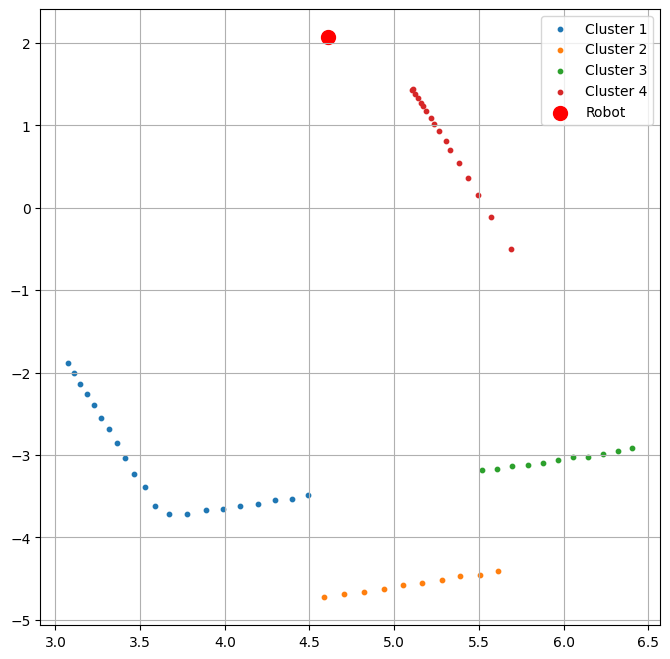

In [ ]:
# Constants for LIDAR
lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

# Extract a single LIDAR snapshot for demonstration
idx = 123
lidar_snapshot = data.loc[idx, 'lidar_1':'lidar_61'].to_numpy()

# Estimate robot positon
pos = estimated_odo_pos(data, idx)

# Convert LIDAR data to Cartesian coordinates
x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

# Convert LIDAR data to global frame
x_global, y_global = transform_to_global(x_local, y_local, pos[0][0], pos[1][0], pos[2][0])

# Combine into a 2D LIDAR snapshot (shape will be (N, 2))
lidar_data = np.array([x_global, y_global]).T  # Transpose to get (N, 2)

# Cluster the filtered LIDAR data
clusters = cluster_points(lidar_data, eps=0.45, min_samples=3)

# Plot
plt.figure(figsize=(8, 8))
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:,0], cluster[:,1],s=10, label=f"Cluster {i+1}")
plt.scatter(pos[0], pos[1], s=100, label="Robot", color="red")
plt.grid()
plt.legend()
plt.show()
plt.close()

### **Line Fitting**

Fitting a line to the clustered data using Douglas-Peucker algorithm.

References: [Douglas-Peucker algorithm](https://cartography-playground.gitlab.io/playgrounds/douglas-peucker-algorithm/)

In [ ]:
# Function to extract the line segments from the simplified LIDAR data
def extract_line_segments(simplified_data):
    """
    Extract line segments from the simplified LIDAR data.

    Parameters:
        simplified_data: ndarray of shape (N, 2) - Simplified LIDAR points.

    Returns:
        List of line segments (each segment is a tuple of two points).
    """
    line_segments = []

    # Iterate over the simplified data and extract segments
    for i in range(len(simplified_data) - 1):
        line_segments.append((simplified_data[i], simplified_data[i + 1]))

    return line_segments

def douglas_peucker(points, epsilon, max_gap=0.1):
    """
    Douglas-Peucker algorithm that also splits disconnected line segments based on a maximum gap.

    Parameters:
        points: ndarray of shape (N, 2) - Input polyline points.
        epsilon: float - Maximum perpendicular distance for simplification.
        max_gap: float - Maximum allowable distance between consecutive points.

    Returns:
        List of line segments (each segment is an ndarray of points).
    """
    def perpendicular_distance(point, line_start, line_end):
        # Vector from line_start to line_end
        line_vec = line_end - line_start
        # Vector from line_start to point
        point_vec = point - line_start

        # Project point_vec onto line_vec to find the closest point on the line
        line_len = np.linalg.norm(line_vec)
        if line_len == 0:
            return np.linalg.norm(point_vec)

        # Normalize line vector
        line_unit_vec = line_vec / line_len
        projection = np.dot(point_vec, line_unit_vec)

        if projection < 0:
            closest_point = line_start
        elif projection > line_len:
            closest_point = line_end
        else:
            closest_point = line_start + projection * line_unit_vec

        # Return the distance from the point to the closest point on the line
        return np.linalg.norm(point - closest_point)

    # Start with the first and last points
    start, end = points[0], points[-1]

    # Find the point with the maximum perpendicular distance to the line
    max_distance = 0
    index = 0
    for i in range(1, len(points) - 1):
        dist = perpendicular_distance(points[i], start, end)
        if dist > max_distance:
            index = i
            max_distance = dist

    # If the max distance is greater than epsilon, recursively simplify
    if max_distance > epsilon:
        # Recurse on the two halves
        left = douglas_peucker(points[:index + 1], epsilon, max_gap)
        right = douglas_peucker(points[index:], epsilon, max_gap)

        # Combine the results
        return left[:-1] + right
    else:
        # If the max distance is less than epsilon, return the start and end points
        return [start, end]

    return segments

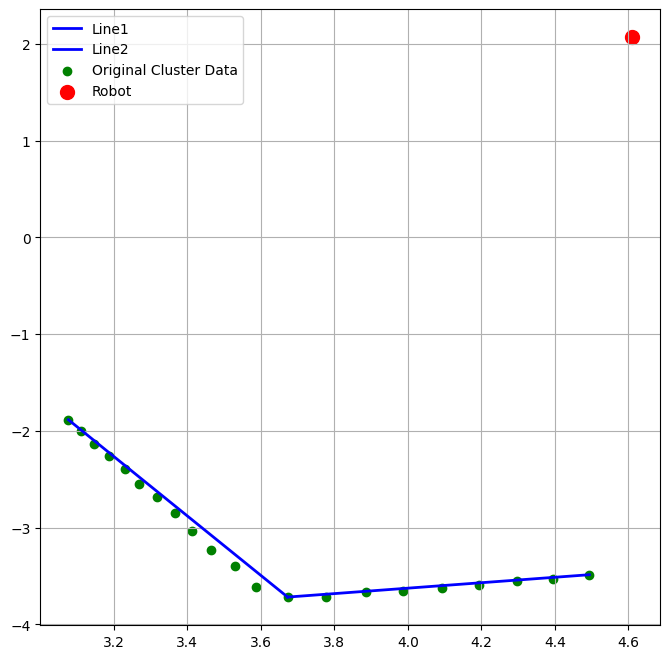

In [ ]:
# Pick the first cluster from the previous example
cluster = clusters[0]

# Apply the Douglas-Peucker algorithm to simplify each cluster
epsilon = 0.06  # Define epsilon for Douglas-Peucker simplification
simplified_cluster = douglas_peucker(cluster, epsilon)

# Extract line segments from the simplified cluster
line_segments = extract_line_segments(simplified_cluster)

# Plot
plt.figure(figsize=(8, 8))
# Plot the filtered line segments
for idx, segment in enumerate(line_segments):
    plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color='blue', linewidth=2, label=f'Line{idx+1}')

# Plot the original cluster data
plt.scatter(cluster[:,0], cluster[:,1], label='Original Cluster Data', color='green', marker='o')
plt.scatter(pos[0], pos[1], s=100, label="Robot", color="red")
plt.grid()
plt.legend()
plt.show()
plt.close()

### **Corner Detection**

Detecting corners using lines intersection and cross product to determine if they are concave or convex.

In [ ]:
def calculate_angle(line1, line2):
    """
    Calculate the angle (in degrees) between two line segments.

    Parameters:
        line1: tuple (start1, end1), points of the first line.
        line2: tuple (start2, end2), points of the second line.

    Returns:
        Angle in degrees between the two line segments.
    """
    # Direction vectors of the two lines
    vec1 = np.array(line1[1]) - np.array(line1[0])
    vec2 = np.array(line2[1]) - np.array(line2[0])

    # Normalize the vectors
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)

    # Dot product and angle
    dot_product = np.dot(norm_vec1, norm_vec2)
    angle_rad = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip for numerical stability
    angle_deg = np.degrees(angle_rad)

    # Return the smaller angle (always ≤ 180°)
    return min(angle_deg, 180 - angle_deg)


def line_intersection(line1, line2, threshold=0.01, extend_by=0.0):
    """
    Calculate the intersection of two line segments, if it exists, with an optional threshold
    for proximity and segment extension.

    Parameters:
        line1: tuple (start1, end1), points of the first line.
        line2: tuple (start2, end2), points of the second line.
        threshold: float, maximum distance from the actual segment bounds to consider an intersection valid.
        extend_by: float, fraction of the line length by which to extend each segment.

    Returns:
        A tuple (x, y) representing the intersection point, or None if there's no intersection.
    """
    start1, end1 = np.array(line1)
    start2, end2 = np.array(line2)

    # Extend the lines if requested
    def extend_line(start, end, factor):
        direction = end - start
        length = np.linalg.norm(direction)
        if length == 0:
            return start, end  # Avoid division by zero
        direction_unit = direction / length
        return start - direction_unit * factor * length, end + direction_unit * factor * length

    if extend_by > 0:
        start1, end1 = extend_line(start1, end1, extend_by)
        start2, end2 = extend_line(start2, end2, extend_by)

    # Extract coordinates
    x1, y1 = start1
    x2, y2 = end1
    x3, y3 = start2
    x4, y4 = end2

    # Calculate the denominator
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if abs(denom) < 1e-10:
        # Lines are parallel or coincident
        return None

    # Calculate the intersection point using determinants
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

    intersection_point = np.array([px, py])

    # Check if the intersection point is near both line segments within the threshold
    def is_point_near_line(point, start, end, threshold):
        # Check if the point is close to the line segment
        line_vec = end - start
        point_vec = point - start
        line_len = np.linalg.norm(line_vec)
        if line_len == 0:
            # If the segment is a point, compare directly
            return np.linalg.norm(point_vec) <= threshold
        line_unit_vec = line_vec / line_len
        projection = np.dot(point_vec, line_unit_vec)
        closest_point = start + np.clip(projection, 0, line_len) * line_unit_vec
        return np.linalg.norm(point - closest_point) <= threshold

    if (
        is_point_near_line(intersection_point, start1, end1, threshold) and
        is_point_near_line(intersection_point, start2, end2, threshold)
    ):
        return tuple(intersection_point)

    return None

def cross_product(v1, v2):
    """Calculate the cross product of two vectors in 2D."""
    return v1[0] * v2[1] - v1[1] * v2[0]

def determine_corner_type(robot_pos, corner, line1, line2):
    """
    Determine if a corner is concave or convex based on the robot's position using cross product.

    Parameters:
        robot_pos: Tuple (x, y) for the robot's position.
        corner: Intersection point (x, y).
        line1: First line segment as a tuple of two points [(x1_start, y1_start), (x1_end, y1_end)].
        line2: Second line segment as a tuple of two points [(x2_start, y2_start), (x2_end, y2_end)].

    Returns:
        String "concave" or "convex".
    """
    robot_pos = np.array([robot_pos[0], robot_pos[1]])
    corner = np.array(corner)

    # Extract points from line1 and line2
    line1_start, line1_end = np.array(line1[0]), np.array(line1[1])
    line2_start, line2_end = np.array(line2[0]), np.array(line2[1])

    # Create vectors from the robot position to the corner
    corner_to_robot_vector = corner - robot_pos

    # Choose the correct direction for each line segment
    # Line1: Vector from corner to start
    line1_vector = line1_start - corner
    # Line2: Vector from corner to end
    line2_vector = line2_end - corner

    # Calculate the cross product to determine the relative orientation
    cross_product_result = cross_product(line1_vector, line2_vector)

    if cross_product_result > 0:
        return "Convex"  # Counter-clockwise angle, outward, convex
    else:
        return "Concave"  # Clockwise angle, inward, concave



def find_corners(robot_pos, line_segments, angle_threshold=5.0, intersection_threshold=0.01):
    """
    Compute corners (intersections) of line segments that form an angle around 90° and classify them.

    Parameters:
        robot_pos: Tuple (x, y) for the robot's position.
        line_segments: List of line segments, where each segment is a tuple (start, end).
        angle_threshold: Allowed deviation from 90° in degrees (e.g., ±5°).
        intersection_threshold: Proximity threshold for intersection validation.

    Returns:
        List of tuples containing intersection points and their type ('concave' or 'convex').
    """
    corners = []

    # Compare each pair of line segments
    for i in range(len(line_segments)):
        for j in range(i + 1, len(line_segments)):
            # Check intersection
            intersection = line_intersection(
                line_segments[i],
                line_segments[j],
                threshold=intersection_threshold
            )
            if intersection:
                # Calculate angle between the two lines
                angle = calculate_angle(line_segments[i], line_segments[j])
                if 90 - angle_threshold <= angle <= 90 + angle_threshold:
                    # Determine concave or convex type
                    corner_type = determine_corner_type(robot_pos, intersection, line_segments[i], line_segments[j])
                    corners.append((intersection, corner_type))

    return corners

Detected Corners:
Corner at: ((3.6731833617629563, -3.7166765371166233), 'Concave')


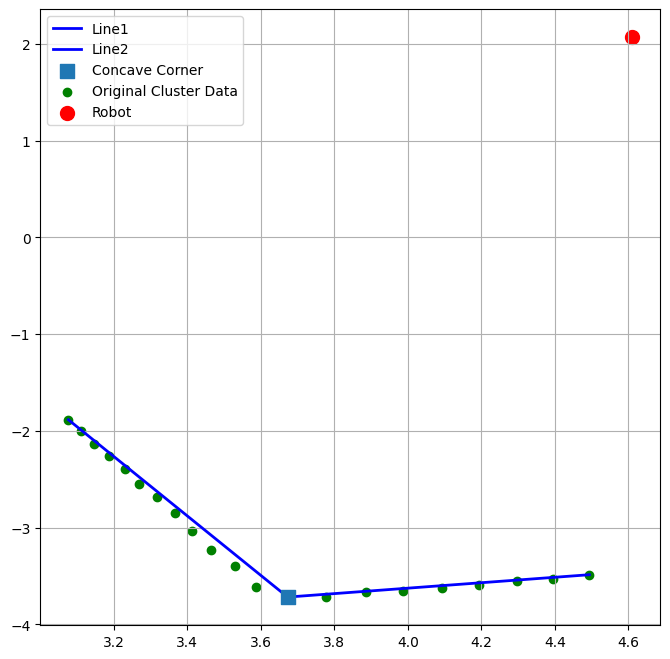

In [ ]:
# Find corners (intersections) for the filtered line segments
angle_threshold = 30.0  # Threshold for angle deviation from 90 degrees
corners = find_corners(pos, line_segments, angle_threshold=angle_threshold)

# Detected Corners
print("Detected Corners:")
for corner in corners:
    print(f"Corner at: {corner}")

# Plot
plt.figure(figsize=(8, 8))
# Plot the filtered line segments
for idx, segment in enumerate(line_segments):
    plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color='blue', linewidth=2, label=f'Line{idx+1}')

# PLot
if len(corners) > 0:
    for corner in corners:
        corner_x = corner[0][0]
        corner_y = corner[0][1]
        corner_type = corner[1]
        # Choose marker based on corner type
        if corner_type == 'Concave':
            marker = 's'  # Square marker for concave corners
        elif corner_type == 'Convex':
            marker = '^'  # Triangle marker for convex corners
        plt.scatter(corner_x, corner_y, s=100, label=f'{corner_type} Corner', zorder=5, marker=marker)

# Plot the original cluster data
plt.scatter(cluster[:,0], cluster[:,1], label='Original Cluster Data', color='green', marker='o')
plt.scatter(pos[0], pos[1], s=100, label="Robot", color="red", marker='o')
plt.grid()
plt.legend()
plt.show()
plt.close()

 **Function that returns the corners given the snapshot lidar data**

In [ ]:
def detect_corners(robot_pos, lidar_snapshot):
  # Constants for LIDAR
  lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

  # Convert LIDAR data to Cartesian coordinates
  x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)


  # Convert LIDAR data to global frame
  x_global, y_global = transform_to_global(
    x_local, y_local,
    float(robot_pos[0]) if isinstance(robot_pos[0], (int, float)) else robot_pos[0].item(),
    float(robot_pos[1]) if isinstance(robot_pos[1], (int, float)) else robot_pos[1].item(),
    float(robot_pos[2]) if isinstance(robot_pos[2], (int, float)) else robot_pos[2].item()
  )


  # Combine into a 2D LIDAR snapshot (shape will be (N, 2))
  lidar_data = np.array([x_global, y_global]).T  # Transpose to get (N, 2)

  # Cluster the filtered LIDAR data
  clusters = cluster_points(lidar_data, eps=0.50, min_samples=4)

  # Store all line segments and corners for later use
  all_line_segments = []
  all_corners = []

  for cluster in clusters:
      # Apply the Douglas-Peucker algorithm to simplify each cluster
      epsilon = 0.06  # Define epsilon for Douglas-Peucker simplification
      simplified_cluster = douglas_peucker(cluster, epsilon)

      # Extract line segments from the simplified cluster
      line_segments = extract_line_segments(simplified_cluster)

      # Find corners (intersections) for the filtered line segments
      angle_threshold = 30.0  # Threshold for angle deviation from 90 degrees
      corners = find_corners(robot_pos, line_segments, angle_threshold=angle_threshold)

      # Append line segments and corners to the global lists
      all_line_segments.extend(line_segments)
      all_corners.extend(corners)

  return all_corners, all_line_segments

In [ ]:
def plot_corners(robot_pos, lidar_data, all_line_segments, corners, frame, output_dir):
  # Constants for LIDAR
  lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

  # Convert LIDAR data to Cartesian coordinates
  x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

  # Convert LIDAR data to global frame
  x_global, y_global = transform_to_global(x_local, y_local, robot_pos[0][0], robot_pos[1][0], robot_pos[2][0])

  # Plotting the original and simplified LIDAR data with corners
  plt.figure(figsize=(8, 6))

  # Plot the original LIDAR data
  plt.scatter(x_global, y_global, label='Original LIDAR Data', color='green', marker='o')

  # Plot the filtered line segments
  for idx, segment in enumerate(all_line_segments):
    plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color='blue', linewidth=2, label=f'Line{idx+1}')

  # PLot
  if len(corners) > 0:
    for corner in corners:
      corner_x = corner[0][0]
      corner_y = corner[0][1]
      corner_type = corner[1]
      # Choose marker based on corner type
      if corner_type == 'Concave':
          marker = 's'  # Square marker for concave corners
      elif corner_type == 'Convex':
          marker = '^'  # Triangle marker for convex corners
      plt.scatter(corner_x, corner_y, s=100, label=f'{corner_type} Corner', zorder=5, marker=marker)

  # Plot robot position
  plt.scatter(robot_pos[0], robot_pos[1], s=100, label="Robot", color="red", marker='o')
  # Add labels and title
  plt.xlabel('X (Local Coordinate)')
  plt.ylabel('Y (Local Coordinate)')
  plt.title(f'LIDAR Data: Frame {frame} - Detected Line Segments and Corners')

  # Display the legend
  plt.legend()

  # Show the plot
  plt.grid(True)

  #plt.show()

  # Optionally, print the detected line segments and corners for inspection
  print("Detected Line Segments:")
  for segment in all_line_segments:
    print(f"Start: {segment[0]}, End: {segment[1]}")

  print("Detected Corners:")
  for corner in corners:
    print(f"Corner at: {corner}")

  # Optionally save the plot as an image in the output directory
  plt.savefig(os.path.join(output_dir, f"frame_{frame}.png"))
  plt.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

output_dir = "frames_corners"
os.makedirs(output_dir, exist_ok=True)

for frame in range(len(data)):
    # Extract a single LIDAR snapshot for demonstration
    lidar_snapshot = data.loc[frame, 'lidar_1':'lidar_61'].to_numpy()
    print("\n")
    print(f"Processing Frame {frame}")

    # Estiamte Odometry
    robot_pos = estimated_odo_pos(data, frame)

    # Detect Corners
    all_corners, all_line_segments = detect_corners(robot_pos, lidar_snapshot)

    # Plot Corners
    plot_corners(robot_pos, lidar_snapshot, all_line_segments, all_corners, frame, output_dir)



Processing Frame 0
Detected Line Segments:
Start: [1.11313506 1.92446568], End: [-0.89691139  1.92743847]
Start: [-0.89691139  1.92743847], End: [-1.00362533  1.89117631]
Start: [-1.00362533  1.89117631], End: [-0.99554366  1.72750768]
Detected Corners:
Corner at: ((-1.0036253344958617, 1.8911763058531872), 'Concave')


Processing Frame 1
Detected Line Segments:
Start: [0.91840166 1.94164947], End: [-0.63859445  1.99428807]
Detected Corners:


Processing Frame 2
Detected Line Segments:
Start: [0.65553137 1.98121572], End: [-0.22576092  2.03388841]
Detected Corners:


Processing Frame 3
Detected Line Segments:
Start: [0.47894335 2.47504003], End: [-0.10708039  2.43802768]
Detected Corners:


Processing Frame 4
Detected Line Segments:
Start: [0.67234182 2.84674611], End: [-0.0824499   2.64832384]
Detected Corners:


Processing Frame 5
Detected Line Segments:
Start: [1.5729439  2.96238194], End: [0.16054248 2.57271407]
Detected Corners:


Processing Frame 6
Detected Line Segments:
Start

### **Corner Detection Results**

Video showing the corner detection results.

In [ ]:
from pathlib import Path
import imageio
import re

# Function to generate a natural sort key
def natural_sort_key(s):
    s = str(s)  # Convert Path object to string
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Assuming output_dir is a Path object and you want to list PNG images
output_dir = Path("frames_corners")

# Get all PNG images in the directory
images = list(output_dir.glob('*.png'))

# Sort the images using the natural sort key
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

frames = [imageio.v2.imread(str(img)) for img in images]

# Create videos directory if it doesn't exist
video_dir = output_dir.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Define video path
video_path = video_dir / 'corners.mp4'

# Write video using frames and desired fps
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 247 images
Video created successfully at videos/corners.mp4!


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('videos/corners.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## **Task2 and Task3**

### **Implementation**

#### State Vector ($\mathbf{x}$):
The state vector includes the robot's pose and the positions of all detected landmarks:
$$
\mathbf{x} =
\begin{bmatrix}
x \\
y \\
\theta \\
l_{1x} \\
l_{1y} \\
\vdots \\
l_{nx} \\
l_{ny}
\end{bmatrix}
$$
- $(x, y, \theta)$: Robot's position and orientation.
- $(l_{ix}, l_{iy})$: Position of the $i$-th landmark.

---

#### Control Inputs ($\mathbf{u}$):
The control signals are derived from odometry:
$$
\mathbf{u} = [\Delta x, \Delta y, \Delta \theta]^T
$$

---

#### Measurements ($\mathbf{z}$):
The measurements are the distance and angle to each detected landmark:
$$
\mathbf{z}_i = [r_i, \phi_i]^T
$$
- $r_i$: Distance to the $i$-th landmark.
- $\phi_i$: Angle relative to the robot's heading.

---

### 1. Prediction Step

The robot's pose is updated using the odometry data ($\Delta x$, $\Delta y$, $\Delta \theta$):

$$
x_{\text{pred}} = x + \Delta x
$$
$$
y_{\text{pred}} = y + \Delta y
$$
$$
\theta_{\text{pred}} = \theta + \Delta \theta
$$

This simple motion model assumes the robot's movements directly update its pose without any complex transformations.

---

### 2. Measurement Update Step

For each detected corner, the expected measurement is computed relative to the robot's predicted pose:

#### Expected Distance:
$$
r_{i,\text{expected}} = \sqrt{(l_{ix} - x_{\text{pred}})^2 + (l_{iy} - y_{\text{pred}})^2}
$$

#### Expected Angle:
$$
\phi_{i,\text{expected}} = \text{atan2}(l_{iy} - y_{\text{pred}}, l_{ix} - x_{\text{pred}}) - \theta_{\text{pred}}
$$

#### Correction:
The difference between the actual measurement $\mathbf{z}_i = [r_i, \phi_i]^T$ and the expected measurement $\mathbf{z}_{i,\text{expected}}$ is used to update the robot's pose and the map. This is often done using a filter such as an **Extended Kalman Filter (EKF)** or other optimization methods.

---

#### Correction Step using Extended Kalman Filter (EKF)

In SLAM, once we have the predicted robot pose and the expected measurements for the landmarks, we update the state vector. This is done by computing the **innovation** (or residual) between the predicted and actual measurements, and then adjusting the state using the **Kalman gain**.

##### Innovation (Residual):
The innovation is the difference between the actual and predicted measurements:
$$
\mathbf{y}_i = \mathbf{z}_i - \mathbf{z}_{i,\text{expected}}
$$
- $\mathbf{z}_i = [r_i, \phi_i]^T$: The actual measurements.
- $\mathbf{z}_{i,\text{expected}} = [r_{i,\text{expected}}, \phi_{i,\text{expected}}]^T$: The predicted measurements.

##### Jacobian Matrices:
To update the state vector using the Kalman filter, we need to compute the Jacobian matrices of the measurement model with respect to the state vector, which describe how the measurements change with respect to the robot's pose and landmark positions. These matrices are used to linearize the non-linear measurement model.

- The **measurement Jacobian** with respect to the state vector:
  $$
  H = \frac{\partial \mathbf{z}_i}{\partial \mathbf{x}}
  $$
  This matrix describes how changes in the robot's pose and landmarks affect the predicted measurements.

- The **process noise** covariance matrix and **measurement noise** covariance matrix describe uncertainties in the motion model and sensor readings. These matrices are essential for updating the state vector and adjusting for errors in prediction and measurement.

##### Kalman Gain:
The Kalman gain is computed as:
$$
K = P \cdot H^T \cdot (H \cdot P \cdot H^T + R)^{-1}
$$
- $P$: The predicted covariance matrix, representing uncertainty in the state estimate.
- $H$: The Jacobian matrix.
- $R$: The measurement noise covariance matrix.

##### State Update:
The state vector is updated using the Kalman gain and the innovation:
$$
\mathbf{x} = \mathbf{x}_{\text{pred}} + K \cdot \mathbf{y}_i
$$
Where $ \mathbf{x}_{\text{pred}} $ is the predicted state vector and $ \mathbf{y}_i $ is the innovation.

##### Covariance Update:
The covariance matrix is also updated to reflect the new uncertainty after incorporating the measurement:
$$
P = (I - K \cdot H) \cdot P
$$
Where $I$ is the identity matrix.

---

### Summary of SLAM Algorithm Steps

1. **Prediction Step:**
   - Update the robot's pose using odometry data (control inputs).

2. **Measurement Update Step:**
   - For each detected landmark, compute the expected distance and angle from the predicted pose.
   - Compute the innovation by comparing actual measurements to expected measurements.
   - Use the Extended Kalman Filter (EKF) to update the robot's pose and the map based on the measurements and predicted state.

3. **State and Covariance Update:**
   - Update the robot's state vector and the covariance matrix using the Kalman gain and the innovation.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

def normalize_angle(angle):
    """
    Normalize an angle to the range [-pi, pi].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

class EKFSLAMState:
	def __init__(self, initial_robot_state: np.ndarray):
		"""Initialize with just robot state [x, y, theta]"""
		self.robot_state_size = len(initial_robot_state)
		self.initial_robot_state = initial_robot_state
		self.state = initial_robot_state.copy()
		# Initialize with some uncertainty in robot pose
		self.covariance = np.diag([0.0, 0.0, 0.0])  # x, y, theta uncertainties
		self.landmarks = {}
		self.total_state_size = self.robot_state_size
		self.Q = np.eye(3)
		self.R = np.zeros((2,2))  # Landmark measurement noise

    # Best param are the comments
		self.std_Q_x = 0 # 0
		self.std_Q_y = 0 # 0
		self.std_Q_theta = 0 # 0
		self.std_Q_x_const = 0.001 # 0.001
		self.std_Q_y_const = 0.001 # 0.001
		self.std_Q_theta_const = np.deg2rad(0.05) # 0.05

		self.std_R_d = 0.0 # 0
		self.std_R_d_const = 0.01 # 0.01
		self.std_R_alpha = 0.0 # 0.0
		self.std_R_alpha_const = np.deg2rad(1) # 1

	def start_over_trajectory(self):
		self.state[:3,:] = self.initial_robot_state.copy()
		self.covariance[:3, :3] = np.diag([0.0, 0.0, 0.0])

	def predict(self, delta: np.ndarray):
		"""
		Predict step using the motion model
		Args:
			delta: [dx, dy, dtheta] motion
		"""
		# Update robot state
		# X(k+1) = X(K) + U
		# U are the control signals dx, dy, dtheta
		self.state[:3, :] += delta
		self.state[2] = normalize_angle(self.state[2]) # Normalize theta between -pi and pi

		# Update Q matrix based on inputs
		self.Q[0, 0] = (self.std_Q_x_const + self.std_Q_x * delta[0, 0])**2
		self.Q[1, 1] = (self.std_Q_y_const + self.std_Q_y * delta[1, 0])**2
		self.Q[2, 2] = (self.std_Q_theta_const + self.std_Q_theta * delta[2, 0])**2

		# Update covariance of robot pose --> consider that R is constant
		# P(k+1)=G*P(K)*G^T + Q
		# G is the jacobian of the state motion variables (Identity in this case)
		G = np.eye(3)
		self.covariance[0:3, 0:3] = G @ self.covariance[0:3, 0:3] @ G.T + self.Q

	def correct(self, landmark_ids: list, measurements: list):
		# observation with values measurement of feature landmark_id
		# measurement needs to be the range and the bearing of the landmark
		# measurement = [range, bearing]

		# Sanity check for row vector
		if (len(landmark_ids) == 0):
			return

		# Robot State
		xr = self.state[0,0]
		yr = self.state[1,0]
		thetar = self.state[2,0]

		all_measurement = np.zeros((2*len(landmark_ids), 1))
		all_z_est = np.zeros((2*len(landmark_ids), 1))

		# Jacobian Matrix taking into account all the observations
		H = np.zeros((2*len(landmark_ids), self.total_state_size))

		self.R = np.zeros((2*len(landmark_ids), 2*len(landmark_ids)))

		for i, landmark_id in enumerate(landmark_ids):
			measurement = measurements[i].reshape(2,1)
			all_measurement[i*2:i*2+2] = measurement.copy()

			# get the landmark estimated position
			landmark_position = self.get_landmark_position(landmark_id)
			xl, yl = landmark_position
			landmark_state_idx = self.landmarks[landmark_id]['state_index']

			# Measurement Estimation based on current state (robot pose and landmark position)
			d_estimated = np.sqrt((xl - xr)**2 + (yl - yr)**2)
			alpha_estimated = np.arctan2(yl - yr, xl - xr) - thetar
			alpha_estimated = normalize_angle(alpha_estimated)
			z_est = np.array([d_estimated, alpha_estimated]).reshape(2,1)
			all_z_est[i*2:i*2+2] = z_est.copy()

			print("Correction phase")
			print("Estimated", z_est)
			print("Measurement", measurement)

			## calculate jacobian matrix of H(X)
			# df1/xr
			# calculate the jacobian matrix for xr, yr and thetar
			H[i*2, 0] = -(xl - xr) / d_estimated
			# df1/yr
			H[i*2, 1] = -(yl - yr) / d_estimated
			# df1/or
			H[i*2, 2] = 0

			# df2/xr
			H[i*2 + 1, 0] = (yl - yr) / d_estimated**2
			# df2/yr
			H[i*2 + 1, 1] = -(xl - xr) / d_estimated**2
			# df2/or
			H[i*2 + 1, 2] = -1

			# Now for the Landmark
			# df1/xl
			H[i*2, landmark_state_idx] = (xl - xr) / d_estimated
			# df1/yl
			H[i*2, landmark_state_idx+1] = (yl - yr) / d_estimated

			# df2/xl
			H[i*2 + 1, landmark_state_idx] = -(yl - yr) / d_estimated**2
			# df2/yr
			H[i*2 + 1, landmark_state_idx+1] = (xl - xr) / d_estimated**2

			# Calculate matrix R
			self.R[2*i, 2*i] = (self.std_R_d_const + self.std_R_d * measurement[0, 0])**2
			self.R[2*i + 1, 2*i + 1] = (self.std_R_alpha_const + self.std_R_alpha * measurement[1, 0])**2

		# Kalman Gain
		K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.R)

		# Innovation
		self.state = self.state + K @ (all_measurement - all_z_est)
		self.state[2] = normalize_angle(self.state[2])

		# Covariance update
		self.covariance = (np.eye(self.total_state_size) - K @ H) @ self.covariance

		# update landmark position
		for key in self.landmarks.keys():
			landmark_state_idx = self.landmarks[key]['state_index']
			self.landmarks[key]['position'] = self.state[landmark_state_idx:landmark_state_idx+2].reshape(2,1)

		return

	def add_landmark(self, landmark_id: int, global_position: np.ndarray, landmark_type) -> None:
		"""Add new landmark observation"""
		if landmark_id in self.landmarks:
			return

		# Extend state vector
		new_state = np.zeros((self.total_state_size + 2, 1))  # +2 for x,y of landmark
		new_state[:self.total_state_size, :] = self.state
		new_state[self.total_state_size:, :] = global_position.reshape(2,1)

		# Extend covariance matrix
		new_covariance = np.zeros((len(new_state), len(new_state)))
		new_covariance[:self.total_state_size, :self.total_state_size] = self.covariance

		# High initial uncertainty for new landmark
		landmark_uncertainty = np.eye(2) * 0.5**2  # 1.5m standard deviation best param
		new_covariance[self.total_state_size:, self.total_state_size:] = landmark_uncertainty

		# Store landmark information
		self.landmarks[landmark_id] = {
			'id': landmark_id,
			'state_index': self.total_state_size,
			'position': global_position.copy(),
	 		'type': landmark_type
		}

		self.state = new_state
		self.covariance = new_covariance
		self.total_state_size += 2

		print("Added new Landmark with id: ", landmark_id, " and position: ", global_position)

	def get_landmark_position(self, landmark_id: int) -> np.ndarray:
		"""Get position of a specific landmark"""
		if landmark_id not in self.landmarks:
			raise KeyError(f"Landmark {landmark_id} not found")
		idx = self.landmarks[landmark_id]['state_index']
		return self.state[idx:idx+2, 0]

def plot_slam_state(ax, slam_state: EKFSLAMState,
                    point_cloud_x=None, point_cloud_y=None,
                    step_number=None, detected_corners=None):
    """Plot the current SLAM state with uncertainty ellipses"""
    # Clear previous plots
    ax.clear()

    # Plot robot pose
    robot_pos = slam_state.state[:2, 0]
    robot_theta = slam_state.state[2, 0]

    # Plot robot position and orientation
    ax.scatter(robot_pos[0], robot_pos[1], c='r', s=100, label='Robot Position')

    if step_number is not None:
        ax.annotate(f'Step {step_number}', (robot_pos[0], robot_pos[1]),
                    xytext=(5, 5), textcoords='offset points',
                    color='black', fontweight='bold')

    # Plot robot orientation arrow
    arrow_length = 0.5
    dx = arrow_length * np.cos(robot_theta)
    dy = arrow_length * np.sin(robot_theta)
    ax.arrow(robot_pos[0], robot_pos[1], dx, dy,
             head_width=0.2, head_length=0.2, fc='r', ec='r')

    # Plot robot uncertainty ellipse
    robot_cov = slam_state.covariance[:2, :2]
    plot_covariance_ellipse(ax, robot_pos, robot_cov, color='r', alpha=0.3)

    # Plot landmarks and their uncertainties
    for landmark_id, landmark in slam_state.landmarks.items():
        pos = slam_state.state[landmark['state_index']:landmark['state_index'] + 2]
        cov = slam_state.covariance[landmark['state_index']:landmark['state_index'] + 2,
                                    landmark['state_index']:landmark['state_index'] + 2]

        # Plot landmark uncertainty
        plot_covariance_ellipse(ax, pos, cov, color='b', alpha=0.3)

        # Plot landmark position
        if landmark['type'] == 'Concave':
             marker = 's'
        elif landmark['type'] == 'Convex':
             marker = '^'
        else:
             marker = '*'
        ax.scatter(pos[0], pos[1], c='b', marker=marker, s=100)
        ax.annotate(f'L{landmark_id}', (pos[0], pos[1]),
                    xytext=(5, 5), textcoords='offset points')

    # Plot point cloud if provided
    if point_cloud_x is not None and point_cloud_y is not None:
        ax.plot(point_cloud_x, point_cloud_y, '.', color='gray', alpha=0.5,
                markersize=2, label='LiDAR points')

    # Plot detected corners if provided
    if detected_corners is not None:
        for corner in detected_corners:
            if corner[1] == 'Concave':
             marker = 's'
            elif corner[1] == 'Convex':
             marker = '^'
            else:
             marker = '*'
            ax.scatter(corner[0][0], corner[0][1], c='g', marker=marker, s=35,
                       label='Detected Corner')
            # Add detection circle
            circle = plt.Circle((corner[0][0], corner[0][1]),
                                0.5, color='g', fill=False, alpha=0.5)
            ax.add_patch(circle)

    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend()

def plot_covariance_ellipse(ax, mean, covariance, confidence=0.95, color='b', alpha=0.3):
    """Plot uncertainty ellipse"""
    eigenvals, eigenvecs = np.linalg.eig(covariance)
    chi2_val = 5.991  # 95% confidence interval
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width, height = 2 * np.sqrt(chi2_val * eigenvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                     color=color, alpha=alpha, fill=True)
    ax.add_patch(ellipse)

def transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta):
    """Transform points from robot's local frame to global frame."""
    # Create rotation matrix
    R = np.array([[np.cos(robot_theta), -np.sin(robot_theta)],
                  [np.sin(robot_theta), np.cos(robot_theta)]])

    # Stack points for vectorized transformation
    local_points = np.vstack((local_x, local_y))

    # Apply rotation and translation
    global_points = R @ local_points
    global_x = global_points[0, :] + robot_x
    global_y = global_points[1, :] + robot_y

    return global_x, global_y

In [ ]:
# Create output directory for frames
output_dir = Path('slam_corners')
output_dir.mkdir(parents=True, exist_ok=True)

# Constants for LIDAR
lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

# Array that will have the model inputs
U = np.zeros((len(data), 3))
U = data.iloc[:][['delta_x', 'delta_y', 'delta_theta']].to_numpy()

# Initialize SLAM state with first pose
initial_pose = np.array([0.0, 0.0, np.pi/2]).reshape(3,1)

# Start SLAM
slam_state = EKFSLAMState(initial_pose)

# Setup parameters
feature_count = 0

steps = range(0, len(data), 1)
# Initialize x_globals and y_globals as empty arrays with shape (0, 1)
x_globals = np.empty((0, 1))
y_globals = np.empty((0, 1))

# Save SLAM Trajectory
slam_trajectory = []

# Main loop for SLAM with multiple landmark handling
plt.figure(figsize=(15, 5))
for k in steps:
	fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

	# New control step
	print(f"\nStep {k}")

	# Predict step - update robot pose
	delta = U[k].reshape(3, 1)
	slam_state.predict(delta)
	print(f"Predicted robot pose: {slam_state.state[:3,0]}")
	slam_trajectory.append(slam_state.state[:3,0])

	# Get predicted state
	xr = slam_state.state[0, 0]
	yr = slam_state.state[1, 0]
	thetar = slam_state.state[2, 0]

	# Observation step - detect corners from sensor data
	lidar_snapshot = data.loc[k, 'lidar_1':'lidar_61'].to_numpy()

	# Detect corners
	detected_corners, _ = detect_corners(slam_state.state[:3,0], lidar_snapshot)

	# Convert lidar data to Cartesian coordinates
	x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)
	x_global, y_global = transform_to_global(
		x_local, y_local,
		xr, yr, thetar
	)

	# Reshape x_global and y_global to (N, 1) for proper appending
	x_global = np.array(x_global).reshape(-1, 1)
	y_global = np.array(y_global).reshape(-1, 1)

	# Append to global coordinates
	x_globals = np.vstack([x_globals, x_global])
	y_globals = np.vstack([y_globals, y_global])

	new_corners_id = []
	revisited_corners_id = []

	new_corners_measurement = []
	revisited_corners_measurement = []

	new_corners_type = []
	revisited_corners_type = []

	# Iterate over corners
	for corner in detected_corners:
		# Get Corner positions
		corner_pos = np.array([corner[0][0], corner[0][1]]).reshape(2, 1)
		xc = corner_pos[0]
		yc = corner_pos[1]
		corner_type = corner[1]
		print(f"{corner_type} corner detected at {corner_pos}")

		# Handle landmark management
		if feature_count == 0:
			# First LandMark
			new_corners_measurement.append(corner_pos)
			new_corners_type.append(corner_type)
			new_corners_id.append(feature_count)
			feature_count += 1
		else:
			# Check if the corner corresponds to an existing landmark
			new_landmark = True
			for landmark_id, landmark in slam_state.landmarks.items():
				landmark_pos = slam_state.get_landmark_position(landmark_id).reshape(2, 1)
				dist = np.linalg.norm(corner_pos - landmark_pos)
				laser_dist_to_corner = np.linalg.norm(corner_pos - np.array([xr, yr]).reshape(2, 1))

				# dynamic distance threshold
				# [0,3]m --> 0.9m distance
				# [3, 6]m --> linear from 1m to 2m distance
				# [6, inf]m --> 2m distance
				x0 = 3 #m
				y0 = 0.15 if (k > 120 and k < 130) else 0.9
				x1 = 8 #m
				y1 = 2 # threshold
				m = (y1 - y0)/(x1 - x0)
				distance_threshold_detection_dynamic = m*laser_dist_to_corner + (y0 - x0*m)

				if distance_threshold_detection_dynamic > y1:
					distance_threshold_detection_dynamic = y1
				elif distance_threshold_detection_dynamic < y0:
					distance_threshold_detection_dynamic = y0

				# Landmark association
				if landmark['type'] == corner_type:
					print(f"Landmark {landmark_id} registered at {landmark_pos}")
					print(f"Distance to detected corner: {dist}")
					if dist < distance_threshold_detection_dynamic:
						new_landmark = False
						# Perform correction for the observed landmark
						detected_corner_range = np.sqrt((xc-xr)**2 + (yc-yr)**2)
						detected_corner_angle = normalize_angle(np.arctan2(yc-yr, xc-xr) - thetar)
						measurement = np.array([detected_corner_range, detected_corner_angle]).reshape(2, 1)

						revisited_corners_id.append(landmark_id)
						revisited_corners_measurement.append(measurement)
						revisited_corners_type.append(corner_type)
						break

			if new_landmark:
				new_corners_measurement.append(corner_pos)
				new_corners_type.append(corner_type)
				new_corners_id.append(feature_count)

				feature_count += 1
				new_landmark = False

	# correct all the corners
	if (len(revisited_corners_id) != 0):
		slam_state.correct(revisited_corners_id, revisited_corners_measurement)
		pass

	# add new corners if any
	if (len(new_corners_id) != 0):
		for i,landmark_id in enumerate(new_corners_id):
			slam_state.add_landmark(landmark_id, new_corners_measurement[i], new_corners_type[i])

	# Plot current state
	plot_slam_state(ax1, slam_state,
					x_globals, y_globals,
					k, detected_corners)  # Pass all global_corners to the plot function
	ax1.set_title(f'SLAM State - Step {k}')

	# Save frame
	output_path = Path(output_dir) / f'frame_{k:04d}.png'
	plt.savefig(output_path, dpi=200)
	#plt.show()
	plt.close(fig)


Step 0
Predicted robot pose: [0.09126056 0.61967913 1.53609746]
Concave corner detected at [[-0.84768466]
 [ 2.54378763]]
Added new Landmark with id:  0  and position:  [[-0.84768466]
 [ 2.54378763]]

Step 1
Predicted robot pose: [0.16590589 1.24454274 1.50859025]

Step 2
Predicted robot pose: [0.12425404 1.95616103 1.49557869]

Step 3
Predicted robot pose: [0.07707704 2.17282523 1.37168778]

Step 4
Predicted robot pose: [0.18758724 2.06170591 1.10086886]

Step 5
Predicted robot pose: [0.16324056 1.97237751 0.84802911]

Step 6
Predicted robot pose: [0.17887458 2.01629721 0.581876  ]
Concave corner detected at [[2.15355238]
 [2.59519422]]
Landmark 0 registered at [[-0.84768466]
 [ 2.54378763]]
Distance to detected corner: 3.0016772646773955
Added new Landmark with id:  1  and position:  [[2.15355238]
 [2.59519422]]

Step 7
Predicted robot pose: [0.27158057 2.03013142 0.29939057]
Concave corner detected at [[2.240657  ]
 [2.63792355]]
Landmark 0 registered at [[-0.84768466]
 [ 2.5437876

<Figure size 1500x500 with 0 Axes>

### **Mapping results**

Video showing the SLAM results.

In [ ]:
from pathlib import Path
import imageio
import re

# Function to generate a natural sort key
def natural_sort_key(s):
    s = str(s)  # Convert Path object to string
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Assuming output_dir is a Path object and you want to list PNG images
output_dir = Path("slam_corners")

# Get all PNG images in the directory
images = list(output_dir.glob('*.png'))

# Sort the images using the natural sort key
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

frames = [imageio.v2.imread(str(img)) for img in images]

# Create videos directory if it doesn't exist
video_dir = output_dir.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Define video path
video_path = video_dir / 'slam_corners.mp4'

# Write video using frames and desired fps
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 247 images
Video created successfully at videos/slam_corners.mp4!


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('videos/slam_corners.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=2000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

#### **Conclusion**

The corner-based SLAM algorithm struggles to achieve successful **loop closure** when the robot re-enters the corridor due to the **absence of previously observed features**. This lack of a great distinctive number of landmarks hinders the algorithm's ability to associate current observations with earlier ones, resulting in data association challenges.

### **Landmarks estimated Position and Covariance**











Once a map is built using SLAM, landmarks serve as reference points for the robot to determine its own position and orientation within the environment.
Landmarks help the robot to "relocalize" itself.

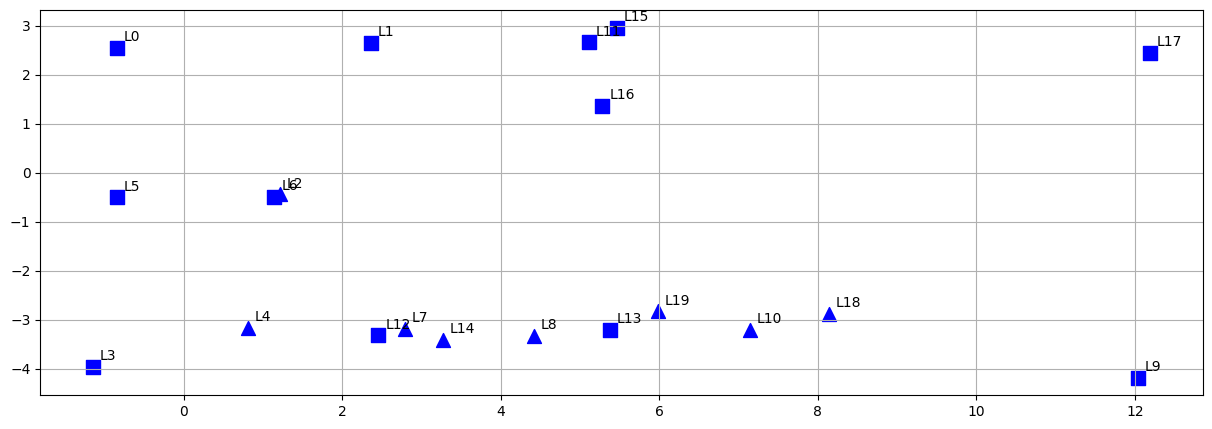

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot landmarks and their uncertainties
for landmark_id, landmark in slam_state.landmarks.items():
    pos = slam_state.state[landmark['state_index']:landmark['state_index'] + 2]
    cov = slam_state.covariance[landmark['state_index']:landmark['state_index'] + 2,
                                landmark['state_index']:landmark['state_index'] + 2]

    # Plot landmark uncertainty
    #plot_covariance_ellipse(ax, pos, cov, color='b', alpha=0.3)

    # Plot landmark position
    if landmark['type'] == 'Concave':
          marker = 's'
    elif landmark['type'] == 'Convex':
          marker = '^'
    else:
          marker = '*'
    ax.scatter(pos[0], pos[1], c='b', marker=marker, s=100)
    ax.annotate(f'L{landmark_id}', (pos[0], pos[1]),
                xytext=(5, 5), textcoords='offset points')
    plt.grid(True)

The final covariance associated with each landmark provides valuable information about the uncertainty in its estimated position.

**High covariance** generally indicates low confidence in the landmark's position estimate. This typically arises when:

*   The landmark was observed only once or a few times. Limited observations lead to higher uncertainty in the estimated position.
*   Observations were made from a single viewpoint or with limited geometric diversity. This can result in ambiguity in determining the landmark's true position.
*   Significant noise or errors were present in the observations, leading to less reliable position estimates.

**Low covariance** signifies high confidence in the landmark's position estimate. This usually occurs when:

*   The landmark was observed multiple times from different viewpoints, providing more robust and accurate position information.
*   Observations were made with good geometric diversity, allowing for more precise triangulation and localization.
*   Observations were relatively noise-free, leading to more reliable position estimates.


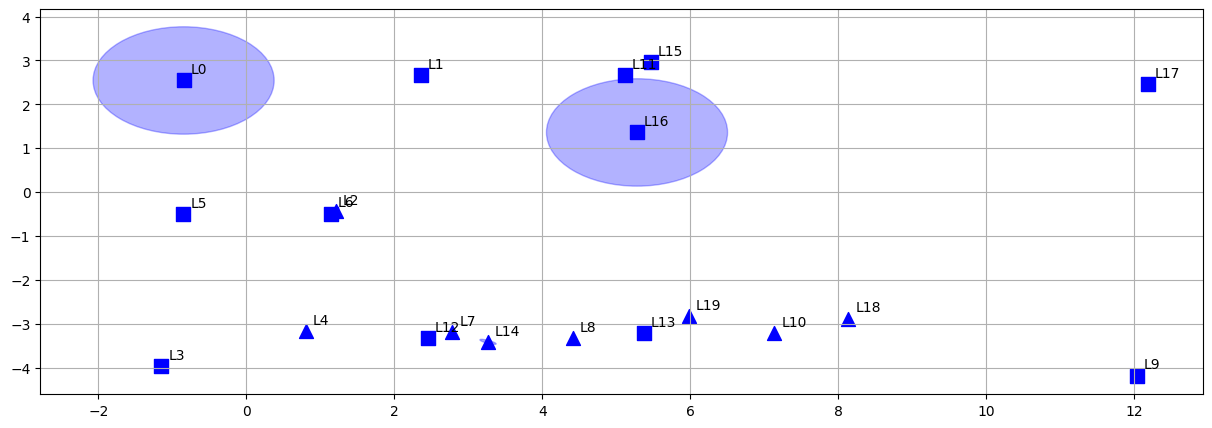

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot landmarks and their uncertainties
for landmark_id, landmark in slam_state.landmarks.items():
    pos = slam_state.state[landmark['state_index']:landmark['state_index'] + 2]
    cov = slam_state.covariance[landmark['state_index']:landmark['state_index'] + 2,
                                landmark['state_index']:landmark['state_index'] + 2]

    # Plot landmark uncertainty
    plot_covariance_ellipse(ax, pos, cov, color='b', alpha=0.3)

    # Plot landmark position
    if landmark['type'] == 'Concave':
          marker = 's'
    elif landmark['type'] == 'Convex':
          marker = '^'
    else:
          marker = '*'
    ax.scatter(pos[0], pos[1], c='b', marker=marker, s=100)
    ax.annotate(f'L{landmark_id}', (pos[0], pos[1]),
                xytext=(5, 5), textcoords='offset points')
    plt.grid(True)

### **Estimated Trajectory: Odometry vs. Corner-based SLAM**


#### **Odometry Estimation**

*   Relies solely on robot motion sensors (e.g., wheel encoders, IMU).
*   Integrates sensor readings over time to estimate position and orientation.
*   Prone to cumulative errors: Small errors in each sensor reading accumulate over time, leading to significant drift in the estimated trajectory.
*   Limited accuracy, especially in long-term operation.

#### **SLAM Estimation**

*   Combines odometry with lidar environmental perception.
*   Builds a map of the environment while simultaneously localizing itself within that map.
*   Uses landmarks or features in the environment to correct odometry errors.
*   Provides more accurate and robust localization, especially over longer distances.

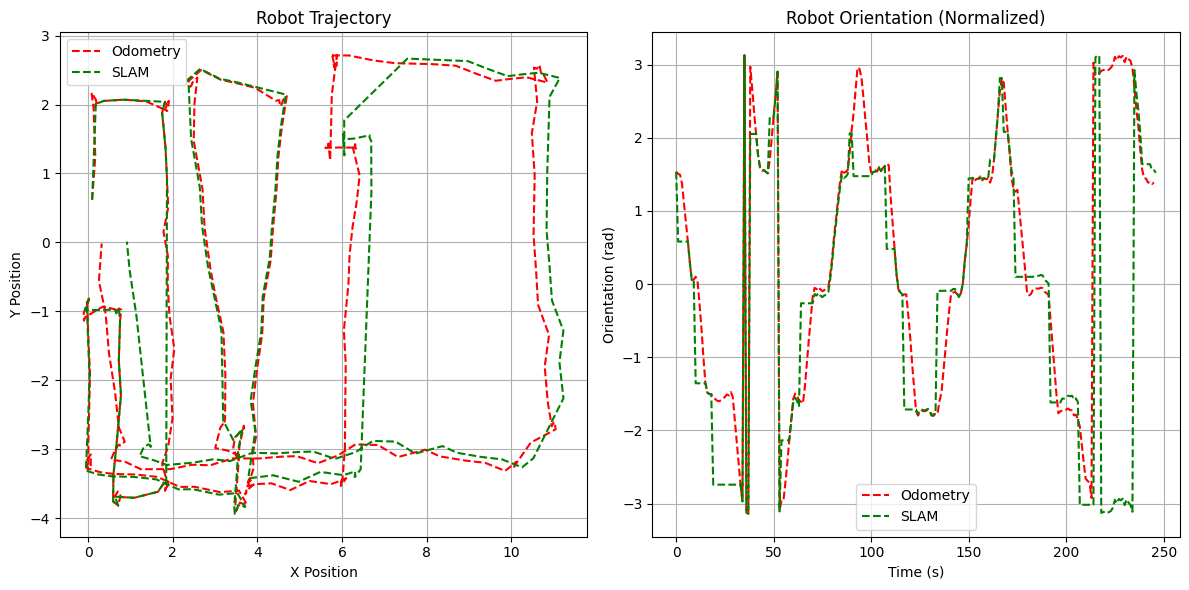

In [ ]:
import matplotlib.pyplot as plt

estimated_pos = []  # Store estimated positions
theta_est_normalized = []  # Store normalized orientation angles

for i in range(1, len(data)):
    # Compute new estimates
    robot_pos = estimated_odo_pos(data, i)
    # Normalize theta
    robot_pos[2] = normalize_angle(robot_pos[2])

    # Append to the result lists
    estimated_pos.append(robot_pos)
    theta_est_normalized.append(robot_pos[2])

# Extract positions for plotting
x_est = [pos[0] for pos in estimated_pos]
y_est = [pos[1] for pos in estimated_pos]

x_slam = [pos[0] for pos in slam_trajectory]
y_slam = [pos[1] for pos in slam_trajectory]
theta_slam_normalized = [normalize_angle(pos[2]) for pos in slam_trajectory]

# Configure plot
plt.figure(figsize=(12, 6))

# Plot robot trajectory
plt.subplot(1, 2, 1)
plt.plot(x_est, y_est, label='Odometry', linestyle='--', color='red')
plt.plot(x_slam, y_slam, label='SLAM', linestyle='--', color='green')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Robot Trajectory')
plt.legend()
plt.grid(True)

# Plot robot orientation
plt.subplot(1, 2, 2)
plt.plot(theta_est_normalized, label='Odometry', linestyle='--', color='red')
plt.plot(theta_slam_normalized, label='SLAM', linestyle='--', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('Robot Orientation (Normalized)')
plt.legend()
plt.grid(True)

# Improve readability and avoid repetition
plt.tight_layout()
plt.show()

# **Line-based SLAM**

This section describes a SLAM implementation using lines as features, inspired by the approach from the ETH Zurich Autonomous Systems Lab ([ETH Zurich Autonomous Systems LAB](https://asl.ethz.ch/education/lectures/autonomous_mobile_robots/spring-2020.html)).

## **Task1**

### **Line Fitting**

Fitting a line to each LIDAR snapshot data using a split and merge algorithm.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create a directory to save frames
output_dir = "frames_lines"
os.makedirs(output_dir, exist_ok=True)

# Split-and-Merge function
def split_and_merge(points, threshold=0.1):
	def perpendicular_distance(point, line_start, line_end):
		num = np.abs((line_end[1] - line_start[1]) * point[0] - (line_end[0] - line_start[0]) * point[1] +
					 line_end[0] * line_start[1] - line_end[1] * line_start[0])
		denom = np.sqrt((line_end[1] - line_start[1]) ** 2 + (line_end[0] - line_start[0]) ** 2)
		return num / denom

	def split(points):
		if len(points) < 5:
			return []

		line_start, line_end = points[0], points[-1]
		max_dist, split_idx = 0, -1

		for i in range(1, len(points) - 1):
			dist = perpendicular_distance(points[i], line_start, line_end)
			if dist > max_dist:
				max_dist = dist
				split_idx = i

		if max_dist > threshold:
			return split(points[:split_idx + 1]) + split(points[split_idx:])
		else:
			return [points]

	return split(points)

# Line fitting function
def fit_line(points):
	x = points[:, 0]
	y = points[:, 1]
	xc, yc = np.mean(x), np.mean(y)

	dX = xc - x
	dY = yc - y

	num = -2 * np.sum(dX * dY)
	denom = np.sum(dY ** 2 - dX ** 2)
	alpha = 0.5 * np.arctan2(num, denom)
	r = xc * np.cos(alpha) + yc * np.sin(alpha)

	if r < 0:
		alpha += np.pi
		if alpha > np.pi:
			alpha -= 2 * np.pi
		r = -r

	return alpha, r

# Function to detect lines from LIDAR data and robot position
def detect_lines_from_lidar(lidar_data, threshold=0.1, min_seg_points=30, dist_threshold=0.02):
    """
    Detect lines from LIDAR data, remove small segments and short distances between points.

    Parameters:
    - lidar_data: A list or array of LIDAR data points, typically in polar coordinates (r, theta).
    - threshold: The distance threshold for the Split-and-Merge algorithm.
    - min_seg_points: Minimum number of points required to consider a segment valid.
    - dist_threshold: Minimum distance required between consecutive points to consider the segment valid.

    Returns:
    - detected_lines: A list of lines represented by (alpha, r), where alpha is the angle and r is the distance.
    """

    # Apply Split-and-Merge to the entire dataset (you need to implement or call this function)
    segments = split_and_merge(lidar_data, threshold=threshold)

    detected_lines = []
    good_segments = []
    # Parameters for filtering and visualization
    for segment in segments:
        segment = np.array(segment)

        # Remove small segments
        if segment.shape[0] < min_seg_points:
            continue

        # Remove segments where consecutive points are too close
        valid_segment = []
        for i in range(1, len(segment)):
            distance = np.linalg.norm(segment[i] - segment[i-1])  # Euclidean distance between consecutive points
            if distance >= dist_threshold:
                valid_segment.append(segment[i])
                good_segments.append(segment)


        # If the valid segment is too short, skip it
        if len(valid_segment) < min_seg_points:
            continue

        # Fit a line to the valid segment
        alpha, r = fit_line(np.array(valid_segment))
        detected_lines.append((alpha, r))

    return detected_lines, good_segments

# Function to detect lines from LIDAR data and robot position
def detect_lines_from_lidar(lidar_data, threshold=0.07, min_seg_points=40):
	# Apply Split-and-Merge to the entire dataset
	segments = split_and_merge(lidar_data, threshold=threshold)

	detected_lines = []

	good_segments = []

	# Parameters for filtering and visualization
	for segment in segments:
		segment = np.array(segment)

		# Remove small segments
		if segment.shape[0] < min_seg_points:
		  continue

		# Fit a line to the segment
		alpha, r = fit_line(segment)
		detected_lines.append((alpha, r))
		good_segments.append(segment)
	return detected_lines, good_segments


# Function to plot the results
def plot_detected_lines(lidar_data, detected_lines, robot_pos, frame):
	plt.figure(figsize=(12, 8))

	# Plot LIDAR data
	plt.scatter(lidar_data[:, 0], lidar_data[:, 1], label='Original LIDAR Data', marker='o', s=10)

	# Plot Robot position
	plt.scatter(robot_pos[0], robot_pos[1], s=100, label="Robot", color="red")

	# Plot each detected line
	for i, (alpha, r) in enumerate(detected_lines):
		# Generate points for the fitted line
		x_fit = np.linspace(lidar_data[:, 0].min(), lidar_data[:, 0].max(), 100)
		y_fit = (r - x_fit * np.cos(alpha)) / np.sin(alpha)
		plt.plot(x_fit, y_fit, linestyle='-', label=f"Segment {i+1} (alpha={alpha * 180 / np.pi:.2f}°, r={r:.2f})", linewidth=2)

	plt.title(f"Detected Lines from LIDAR Data - Frame {frame}")
	plt.xlabel("X (m)")
	plt.ylabel("Y (m)")
	plt.legend()
	plt.grid()
	plt.xlim(lidar_data[:, 0].min() - 1, lidar_data[:, 0].max() + 1)
	plt.ylim(lidar_data[:, 1].min() - 1, lidar_data[:, 1].max() + 1)
	#plt.show()
	# Optionally save the plot as an image in the output directory
	plt.savefig(os.path.join(output_dir, f"frame_{frame}.png"))
	plt.close()

In [ ]:
for frame in range(len(data)):
	print(f"Processing frame {frame}")
	# Robot position
	#robot_pos = estimated_odo_pos(data, frame)  # Replace with actual function to get robot position

	# Line fitting in local frame
	robot_pos = np.array([0, 0, 0]).reshape(-1, 1)

	# Get LIDAR snapshot for this frame
	lidar_snapshot = data.loc[frame, 'lidar_1':'lidar_61'].to_numpy()

	# Convert LIDAR snapshot to Cartesian coordinates
	lidar_angles = np.radians(np.linspace(-30, 30, 61))  # LIDAR angles from -30° to 30°
	x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

	# Transform from local to global coordinates (replace with actual transform)
	#x_global, y_global = transform_to_global(x_local, y_local, float(robot_pos[0][0]), float(robot_pos[1][0]), float(robot_pos[2][0]))

	# Generate the LIDAR data
	lidar_data = np.column_stack((x_local, y_local))

	# Detect lines from LIDAR data
	detected_lines, _= detect_lines_from_lidar(lidar_data, threshold=0.06, min_seg_points=7)

	# Plot the results for this frame
	plot_detected_lines(lidar_data, detected_lines, robot_pos, frame)

Processing frame 0
Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Processing frame 48
Processing frame 49
Processing

In [ ]:
from pathlib import Path
import imageio
import re

# Function to generate a natural sort key
def natural_sort_key(s):
	s = str(s)  # Convert Path object to string
	return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Assuming output_dir is a Path object and you want to list PNG images
output_dir = Path("frames_lines")

# Get all PNG images in the directory
images = list(output_dir.glob('*.png'))

# Sort the images using the natural sort key
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

frames = [imageio.v2.imread(str(img)) for img in images]

# Create videos directory if it doesn't exist
video_dir = output_dir.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Define video path
video_path = video_dir / 'frames_lines.mp4'

# Write video using frames and desired fps
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 247 images
Video created successfully at videos/frames_lines.mp4!


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/frames_lines.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## **Task2 and Task3**

### **Implementation**

### **Key Idea**

Similar to corner-based SLAM, line-based SLAM builds a map of the environment and tracks the robot's pose simultaneously. However, instead of using landmarks like corners, this approach uses lines as features to represent the environment.

The measurement model is the following:

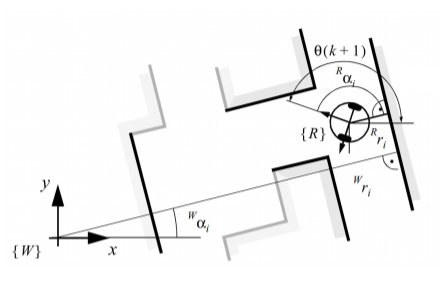

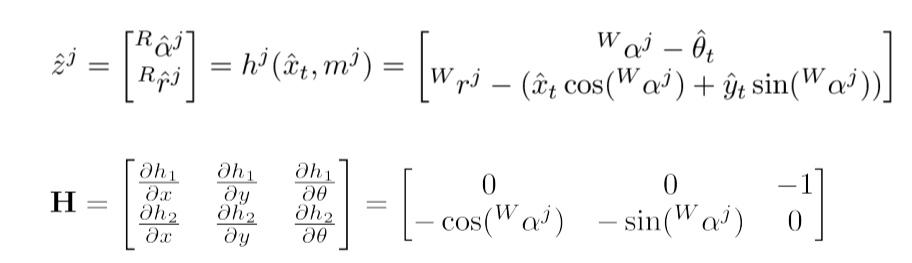

Lines are parameterized using two values:
$$
m^i =
\begin{bmatrix}
\alpha^i \\
r^i
\end{bmatrix}
$$
where:

* $\alpha^i$: The orientation of the line relative to a reference frame.
* $r^i$: The perpendicular distance from the origin of the reference frame to the line.

Frames of Reference
* World Frame: Lines in the map are defined relative to the world frame $W$.
* Body Frame: Lines observed by the robot’s sensor are defined relative to the robot’s body frame $R$.

**Predicted Measurement**

To match observed lines to the map, the SLAM system predicts the measurement of a line in the robot’s frame based on its pose and the map.

The predicted measurement $\hat{z}^j$ for a line $m^j$ is given by:
$\hat{z}^j =
\begin{bmatrix}
^R\alpha^j \\
^Rr^j
\end{bmatrix}
= h^j(\hat{x}_t, m^j)$
where $h^j(\hat{x}_t, m^j)$ transforms a line from the world frame to the robot’s frame using the robot's estimated pose $\hat{x}_t = \begin{bmatrix} \hat{x}_t, \hat{y}_t, \hat{\theta}_t \end{bmatrix}$.

Breaking it down further:
$\hat{z}^j =
\begin{bmatrix}
^W \alpha^j - \hat{\theta}_t \\
^Wr^j - \left(\hat{x}_t \cos(^W\alpha^j) + \hat{y}_t \sin(^W\alpha^j)\right)
\end{bmatrix}$
where:

* $^W\alpha^j$: The orientation of the line in the world frame.
* $^Wr^j$: The distance of the line from the world frame origin.
* $\hat{\theta}_t$: The robot's estimated orientation.
* $\hat{x}_t, \hat{y}_t$: The robot's estimated position.

This transformation aligns the line in the world frame with the robot's body frame for measurement comparison.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression


def normalize_angle(angle):
    """
    Normalize an angle to the range [-pi, pi].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

class EKFSLAMState:
    def __init__(self, initial_robot_state: np.ndarray):
        """Initialize with just robot state [x, y, theta]"""
        self.robot_state_size = len(initial_robot_state)
        self.initial_robot_state = initial_robot_state
        self.state = initial_robot_state.copy()
        # Initialize with some uncertainty in robot pose
        self.covariance = np.diag([0.0, 0.0, 0.0])  # x, y, theta uncertainties
        self.landmarks = {}
        self.total_state_size = self.robot_state_size
        self.Q = np.eye(3) # State noise
        self.R = np.zeros((2,2))  # Landmark measurement noise

        # Best params are the comments
        self.std_Q_x = 0.025 # 0.0025
        self.std_Q_y = 0.025 # 0.0025
        self.std_Q_theta = 0.025 # 0.0025
        self.std_Q_x_const = 0.0 # 0.0
        self.std_Q_y_const = 0.0 # 0.0
        self.std_Q_theta_const = 0 # 0.0

        self.std_R_r_const = 0.05 # 0.05
        self.std_R_alpha_const = np.deg2rad(5) # 5

        self.clusters_size = []
        self.clusters_centroid = []
        self.clusters_xlims = []
        self.clusters_ylims = []

    def process_cluster(self, id: int, cluster: np.ndarray):
        """Update the cluster information"""
        # check if it is the first time that this cluster appears
        if id == len(self.clusters_size):
            self.clusters_size.append(cluster.shape[0])
            self.clusters_centroid.append(np.mean(cluster, axis=0))
            self.clusters_xlims.append([cluster[:, 0].min(), cluster[:, 0].max()])
            self.clusters_ylims.append([cluster[:, 1].min(), cluster[:, 1].max()])
        else:
            # take into consideration the previous value of the centroid
            self.clusters_centroid[id] = (self.clusters_centroid[id]*self.clusters_size[id] + np.sum(cluster, axis=0))/(self.clusters_size[id] + cluster.shape[0])
            self.clusters_size[id] += cluster.shape[0]

            # update the limits
            self.clusters_xlims[id][0] = min(self.clusters_xlims[id][0], cluster[:, 0].min())
            self.clusters_xlims[id][1] = max(self.clusters_xlims[id][1], cluster[:, 0].max())
            self.clusters_ylims[id][0] = min(self.clusters_ylims[id][0], cluster[:, 1].min())
            self.clusters_ylims[id][1] = max(self.clusters_ylims[id][1], cluster[:, 1].max())

        return

    def H_elements(self, landmark_id: int) -> tuple:
        """Given a landmark id, return the elements of the Jacobian matrix H for that landmark"""
        landmark_state_idx = self.landmarks[landmark_id]['state_index']
        alpha_world = self.state[landmark_state_idx, 0]

        H_pos = np.zeros((2, 3))
        H_pos[0, 2] = -1
        H_pos[1, 2] = 0
        H_pos[1, 0] = -np.cos(alpha_world)
        H_pos[1, 1] = -np.sin(alpha_world)

        H_landmark = np.zeros((2, 2))
        H_landmark[0, 0] = 1
        H_landmark[1, 1] = 0
        H_landmark[1, 0] = self.state[0, 0]*np.sin(alpha_world) - self.state[1, 0]*np.cos(alpha_world)
        H_landmark[1, 1] = 1

        return H_pos, H_landmark

    def normalize_line_parameters(self, line_parameters: np.ndarray):
        alpha = line_parameters[0, 0]
        r = line_parameters[1, 0]
        if r < 0:
            negated = True
            alpha += np.pi
            if alpha > np.pi:
                alpha -= 2 * np.pi
            r = -r
        else:
            negated = False
        line_parameters[0, 0] = normalize_angle(alpha)
        line_parameters[1, 0] = r

        return line_parameters, negated

    def measurement_function(self, landmark_id: int) -> np.ndarray:
        """
        Given a landmark id, return the expected
        measurement z (range, bearing) in the robot frame
        """
        landmark_state_idx = self.landmarks[landmark_id]['state_index']
        alpha_world = self.state[landmark_state_idx, 0]
        r_world = self.state[landmark_state_idx + 1, 0]

        alpha_robot = (alpha_world - self.state[2, 0])
        r_robot = r_world - (self.state[0, 0]*np.cos(alpha_world) + self.state[1, 0]*np.sin(alpha_world))
        line_parameters, negated = self.normalize_line_parameters(np.array([alpha_robot, r_robot]).reshape(2, 1))

        return line_parameters, negated

    def measurement_robot_to_world(self, measurement_robot_frame: np.ndarray):
        """Convert measurement from robot frame to world frame"""
        measurement_world = np.zeros((2, 1))
        # alpha
        measurement_world[0, 0] = measurement_robot_frame[0, 0] + self.state[2, 0]
        # r
        measurement_world[1, 0] = measurement_robot_frame[1, 0] + (self.state[0, 0]*np.cos(measurement_world[0, 0]) + self.state[1, 0]*np.sin(measurement_world[0, 0]))

        measurement_world, negated = self.normalize_line_parameters(measurement_world)
        return measurement_world

    def measurement_world_to_robot(self, measurement_world_frame: np.ndarray):
        """Convert measurement from world frame to robot frame"""
        measurement_robot = np.zeros((2, 1))
        # alpha
        measurement_robot[0, 0] = measurement_world_frame[0, 0] - self.state[2, 0]
        # r
        measurement_robot[1, 0] = measurement_world_frame[1, 0] - (self.state[0, 0]*np.cos(measurement_world_frame[0, 0]) + self.state[1, 0]*np.sin(measurement_world_frame[0, 0]))

        measurement_robot, negated = self.normalize_line_parameters(measurement_robot)
        return measurement_robot


    def associated_landmark_innovation_Hmatrix(self, measurement_robot_frame: np.ndarray):
        """
        Returns the landmark id associated with the measurement if any
        and the innovation and H matrix for the associated landmark

        Returns None, None, None if no landmark is associated
        """

        measurement_world = self.measurement_robot_to_world(measurement_robot_frame)

        n_landmarks = len(self.landmarks)
        # In case no landmarks are present
        if (n_landmarks == 0):
            return None, None, None

        # Initialize arrays to store distances and innovations
        mahalanobis_distances = np.zeros(n_landmarks)
        innovations = []
        H_matrices = []
        landmark_ids = []

        parameters_world_measurement = np.zeros((2, n_landmarks))

        # Set gate threshold for chi-square with 2 degrees of freedom (95% confidence)
        gate_threshold = 7 # You can adjust this value based on desired confidence

        # print(f"---- Landmark Association Phase ----")

        # For each landmark, calculate innovation and Mahalanobis distance
        for i,landmark_id in enumerate(self.landmarks.keys()):
            # calculate the expected measurement in the robot frame
            z_est, r_negated = self.measurement_function(landmark_id)
            landmark_state_idx = self.landmarks[landmark_id]['state_index']
            landmark_global_from_state = self.state[landmark_state_idx:landmark_state_idx+2, :]

            measurement_landmark_global = self.measurement_robot_to_world(z_est)

            # print(f"Landmark {landmark_id} - Expected Measurement (robot): {z_est}")

            # Test if the value in state is the same as the one after conversion
            # print(f"Landmark {landmark_id} - Expected Measurement (global): {measurement_landmark_global}")
            # print(f"Landmark {landmark_id} - Landmark Position from state (global): {landmark_global_from_state}")

            # print(f"Measurement (robot): {measurement_robot_frame}")
            #parameters_world_measurement[:, i] = self.measurement_robot_to_world(measurement_robot_frame)

            # calculate the innovation --> difference between the measurement and the expected measurement
            innovation = measurement_robot_frame - z_est
            innovation[0, 0] = normalize_angle(innovation[0, 0])

            # print(f"Landmark {landmark_id} (meas_rob - land_rob_est) - Innovation: {innovation}")
            #print("Measurement robot frame:", measurement_robot_frame)
            #print("Z estimated:", z_est)

            # Get Jacobian matrices for this landmark
            H_pos, H_landmark = self.H_elements(landmark_id)
            if r_negated:
                H_landmark[1, :] *= -1

            # Construct full H matrix
            landmark_state_idx = self.landmarks[landmark_id]['state_index']
            H = np.zeros((2, self.state.shape[0]))
            H[:, :3] = H_pos
            H[:, landmark_state_idx:landmark_state_idx+2] = H_landmark

            # Calculate innovation covariance
            # Assuming R is the measurement noise covariance
            R = np.diag([self.std_R_alpha_const, self.std_R_r_const])  # Adjust these values based on your sensor noise
            S = H @ self.covariance @ H.T + R

            # Calculate Mahalanobis distance
            mahalanobis_dist = np.sqrt(innovation.T @ np.linalg.inv(S) @ innovation)

            # Store results
            landmark_ids.append(landmark_id)
            mahalanobis_distances[i] = mahalanobis_dist
            innovations.append(innovation)
            H_matrices.append(H)


        # Find best match (minimum Mahalanobis distance)
        # min_dist_idx = np.argmin(mahalanobis_distances)
        # min_dist = mahalanobis_distances[min_dist_idx]
        #print("Minimum distance Mahalanobis: ", min_dist)

        #print("Innovations: ", innovations)
        # get a mask for innovations where r - r_est is below a threshold
        r_threshold = 0.85 # 0.85
        innovations_arr = np.zeros((2, n_landmarks))
        for ind_aux in range(len(innovations)):
            innovations_arr[:, ind_aux] = innovations[ind_aux].reshape(2)
        #print(innovations_arr)
        mask_r = np.abs(innovations_arr[1, :]) < r_threshold

        # do the same for alpha threshold
        alpha_threshold = np.deg2rad(25) # 40
        mask_alpha = np.abs(innovations_arr[0, :]) < alpha_threshold

        # get the cases where both thresholds are satisfied
        mask = np.logical_and(mask_r, mask_alpha)

        # get the indices of the cases where both thresholds are satisfied
        indices = np.where(mask)[0]

        # get the smallest distance among the cases where both thresholds are satisfied
        if len(indices) > 0:
            min_dist_idx = np.argmin(mahalanobis_distances[indices])

            # Match found - update existing landmark
            matched_landmark_id = landmark_ids[indices[min_dist_idx]]
            return matched_landmark_id, innovations[indices[min_dist_idx]], H_matrices[indices[min_dist_idx]]

        # Case that a match is found
        # # Case that a match is found
        # if min_dist < gate_threshold:
        # 	# Match found - update existing landmark
        # 	matched_landmark_id = landmark_ids[min_dist_idx]
        # 	return matched_landmark_id, innovations[min_dist_idx], H_matrices[min_dist_idx]

        # Case no match found
        return None, None, None

    def predict(self, delta: np.ndarray):
        """
        Predict step using the motion model
        Args:
            delta: [dx, dy, dtheta] motion
        """
        # Update robot state
        # X(k+1) = X(K) + U
        # U are the control signals dx, dy, dtheta
        self.state[:3, :] += delta
        self.state[2] = normalize_angle(self.state[2]) # Normalize theta between -pi and pi

        # Update Q matrix based on inputs
        self.Q[0, 0] = (self.std_Q_x_const + self.std_Q_x * delta[0, 0])**2
        self.Q[1, 1] = (self.std_Q_y_const + self.std_Q_y * delta[1, 0])**2
        self.Q[2, 2] = (self.std_Q_theta_const + self.std_Q_theta * delta[2, 0])**2

        # Update covariance of robot pose --> consider that R is constant
        # P(k+1)=G*P(K)*G^T + Q
        # G is the jacobian of the state motion variables (Identity in this case)
        G = np.eye(3)
        self.covariance[0:3, 0:3] = G @ self.covariance[0:3, 0:3] @ G.T + self.Q

    def normalize_lines_parameters(self):
        # Normalize all the line parameters
        for key in self.landmarks.keys():
            landmark_state_idx = self.landmarks[key]['state_index']

            if self.state[landmark_state_idx+1, 0] < 0:
                self.state[landmark_state_idx] += np.pi
                if self.state[landmark_state_idx] > np.pi:
                    self.state[landmark_state_idx] -= 2 * np.pi
                self.state[landmark_state_idx+1, 0] = -self.state[landmark_state_idx+1, 0]

            self.state[landmark_state_idx] = normalize_angle(self.state[landmark_state_idx])

    def correct(self, associated_landmark_ids: list, innovations: list, H_matrices: list):

        # Robot State
        xr = self.state[0,0]
        yr = self.state[1,0]
        thetar = self.state[2,0]

        # Store all the inovations concerning all the landmarks
        all_innovations = np.zeros((2*len(associated_landmark_ids), 1))

        # Big H and Rmatrix to account for all the measurements
        bigH = np.zeros((2*len(associated_landmark_ids), self.total_state_size))
        R = np.diag([self.std_R_alpha_const**2, self.std_R_r_const**2])
        bigR = np.zeros((2*len(associated_landmark_ids), 2*len(associated_landmark_ids)))

        for i, landmark_id in enumerate(associated_landmark_ids):
            landmark_state_idx = self.landmarks[landmark_id]['state_index']

            all_innovations[i*2:i*2+2] = innovations[i].copy()

            bigH[i*2:i*2+2, :] = H_matrices[i].copy()

            bigR[i*2:i*2+2, i*2:i*2+2] = R

        # Kalman Gain
        K = self.covariance @ bigH.T @ np.linalg.inv(bigH @ self.covariance @ bigH.T + bigR)

        # Innovation
        self.state = self.state + K @ all_innovations
        self.state[2] = normalize_angle(self.state[2])

        # Normalize all the line parameters
        self.normalize_lines_parameters()

        # Covariance update
        self.covariance = (np.eye(self.total_state_size) - K @ bigH) @ self.covariance

        # update landmark parameters
        for key in self.landmarks.keys():
            landmark_state_idx = self.landmarks[key]['state_index']
            self.landmarks[key]['parameters'] = self.state[landmark_state_idx:landmark_state_idx+2].reshape(2,1)

        return

    def add_landmark(self, landmark_id: int, parameters: np.ndarray) -> None:
        """Add new landmark observation"""
        if landmark_id in self.landmarks:
            return

        # Extend state vector
        new_state = np.zeros((self.total_state_size + 2, 1))  # +2 for x,y of landmark
        new_state[:self.total_state_size, :] = self.state
        new_state[self.total_state_size:, :] = parameters.reshape(2,1)

        # Extend covariance matrix
        new_covariance = np.zeros((len(new_state), len(new_state)))
        new_covariance[:self.total_state_size, :self.total_state_size] = self.covariance

        # High initial uncertainty for new landmark
        landmark_uncertainty = np.eye(2)
        landmark_uncertainty[0,0] = np.deg2rad(20)**2  # 10 degree standard deviation
        landmark_uncertainty[0,0] = 0.2**2  # 10 degree standard deviation
        new_covariance[self.total_state_size:, self.total_state_size:] = landmark_uncertainty

        # Store landmark information
        self.landmarks[landmark_id] = {
            'id': landmark_id,
            'state_index': self.total_state_size,
            'parameters': parameters.copy(),
        }

        self.state = new_state
        self.covariance = new_covariance
        self.total_state_size += 2

        #print("Added new Landmark with id: ", landmark_id, " and parameters: ", parameters)

    def get_landmark_parameters(self, landmark_id: int) -> np.ndarray:
        """Get the parameters of a specific landmark"""
        if landmark_id not in self.landmarks:
            raise KeyError(f"Landmark {landmark_id} not found")
        return self.landmarks[landmark_id]['parameters']

def plot_slam_state(ax, slam_state: EKFSLAMState,
                    point_cloud_x=None, point_cloud_y=None,
                    step_number=None, detected_corners=None):
    """Plot the current SLAM state with uncertainty ellipses"""
    # Clear previous plots
    ax.clear()

    # Plot robot pose
    robot_pos = slam_state.state[:2, 0]
    robot_theta = slam_state.state[2, 0]

    # Plot robot position and orientation
    ax.scatter(robot_pos[0], robot_pos[1], c='r', s=100)

    if step_number is not None:
        ax.annotate(f'Step {step_number}', (robot_pos[0], robot_pos[1]),
                    xytext=(5, 5), textcoords='offset points',
                    color='black', fontweight='bold')

    # Plot robot orientation arrow
    arrow_length = 0.5
    dx = arrow_length * np.cos(robot_theta)
    dy = arrow_length * np.sin(robot_theta)
    ax.arrow(robot_pos[0], robot_pos[1], dx, dy,
             head_width=0.2, head_length=0.2, fc='r', ec='r')

    # Plot robot uncertainty ellipse
    robot_cov = slam_state.covariance[:2, :2]
    plot_covariance_ellipse(ax, robot_pos, robot_cov, color='r', alpha=0.3)

    # Plot point cloud if provided
    if point_cloud_x is not None and point_cloud_y is not None:
        ax.plot(point_cloud_x, point_cloud_y, '.', color='gray', alpha=0.5,
                markersize=2)

    # Plot landmarks and their uncertainties
    for landmark_id, landmark in slam_state.landmarks.items():
        line_params = slam_state.state[landmark['state_index']:landmark['state_index'] + 2]
        alpha = line_params[0, 0]
        r = line_params[1, 0]
        # get the cluster info
        cluster_id = landmark_id
        cluster_size = slam_state.clusters_size[cluster_id]
        cluster_centroid = slam_state.clusters_centroid[cluster_id]
        cluster_xlims = slam_state.clusters_xlims[cluster_id]
        cluster_ylims = slam_state.clusters_ylims[cluster_id]

        try:
            x, y = get_line_points_from_hesse(alpha, r, xlim=(cluster_xlims[0] - 0.5, cluster_xlims[1] + 0.5), ylim=(cluster_ylims[0] - 0.5, cluster_ylims[1] + 0.5))
        except:
            x = None
            y = None

        if x is not None and y is not None:
          ax.plot(x, y, color='m', alpha=0.5)

        # draw the centroid of the cluster
        ax.scatter(cluster_centroid[0], cluster_centroid[1], c='m', s=100)
        # draw small text near cluster with the landmark id
        ax.annotate(f'C{cluster_id}', (cluster_centroid[0], cluster_centroid[1]),
                    xytext=(5, 5), textcoords='offset points',
                    color='black', fontweight='bold')

    ax.grid(True)
    ax.legend()

def plot_covariance_ellipse(ax, mean, covariance, confidence=0.95, color='b', alpha=0.3):
    """Plot uncertainty ellipse"""
    eigenvals, eigenvecs = np.linalg.eig(covariance)
    chi2_val = 5.991  # 95% confidence interval
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    width, height = 2 * np.sqrt(chi2_val * eigenvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                     color=color, alpha=alpha, fill=True)
    ax.add_patch(ellipse)

def transform_to_global(local_x, local_y, robot_x, robot_y, robot_theta):
    """Transform points from robot's local frame to global frame."""
    # Create rotation matrix
    R = np.array([[np.cos(robot_theta), -np.sin(robot_theta)],
                  [np.sin(robot_theta), np.cos(robot_theta)]])

    # Stack points for vectorized transformation
    local_points = np.vstack((local_x, local_y))

    # Apply rotation and translation
    global_points = R @ local_points
    global_x = global_points[0, :] + robot_x
    global_y = global_points[1, :] + robot_y

    return global_x, global_y


def get_line_points_from_hesse(alpha, r, xlim=(-15, 15), ylim=(-15, 15)):
    """
    Get points to draw a line given Hesse normal form parameters (alpha, r).

    Args:
        alpha: angle in radians of the normal vector from origin to line
        r: distance from origin to line
        xlim: x-axis limits (tuple)
        ylim: y-axis limits (tuple)

    Returns:
        tuple: (x_points, y_points) arrays of length 2 for plotting
        Returns None if no valid points found
    """
    # Normalize alpha to [-pi, pi] and handle negative r
    if r < 0:
        alpha += np.pi
        r = -r
    alpha = ((alpha + np.pi) % (2 * np.pi)) - np.pi

    # For near-vertical lines (alpha close to ±π/2)
    if abs(abs(alpha) - np.pi/2) < 1e-10:
        x = r * np.sign(np.cos(alpha))
        if xlim[0] <= x <= xlim[1]:
            return np.array([x, x]), np.array([ylim[0], ylim[1]])
        return None

    # For near-horizontal lines (alpha close to 0 or π)
    if abs(alpha % np.pi) < 1e-10:
        y = r * np.sign(np.sin(alpha))
        if ylim[0] <= y <= ylim[1]:
            return np.array([xlim[0], xlim[1]]), np.array([y, y])
        return None

    # For all other lines
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)

    # Calculate all possible intersection points at once
    # Vertical boundaries
    x_vert = np.array(xlim)
    y_vert = (r - x_vert * cos_a) / sin_a

    # Horizontal boundaries
    y_horz = np.array(ylim)
    x_horz = (r - y_horz * sin_a) / cos_a

    # Stack all points
    x_points = np.concatenate([x_vert, x_horz])
    y_points = np.concatenate([y_vert, y_horz])

    # Filter points within bounds
    mask = (x_points >= xlim[0]) & (x_points <= xlim[1]) & \
           (y_points >= ylim[0]) & (y_points <= ylim[1])

    x_points = x_points[mask]
    y_points = y_points[mask]

    # Return None if we don't have enough points
    if len(x_points) < 2:
        return None

    # Sort points and return first two
    sort_idx = np.argsort(x_points)
    return x_points[sort_idx][:2], y_points[sort_idx][:2]

In [ ]:
# Create output directory for frames
output_dir = Path('slam_lines')
output_dir.mkdir(parents=True, exist_ok=True)

# Constants for LIDAR
lidar_angles = np.radians(np.linspace(-30, 30, 61))  # Angles from -30° to +30° in radians

# Array that will have the model inputs
U = np.zeros((len(data), 3))
U = data.iloc[:][['delta_x', 'delta_y', 'delta_theta']].to_numpy()

# Initialize SLAM state with first pose
initial_pose = np.array([0.0, 0.0, np.pi/2]).reshape(3,1)

# Start SLAM
slam_state = EKFSLAMState(initial_pose)

# Setup parameters
feature_count = 0

# Save trajectories
predicted_poses = np.zeros((len(data), 3))
corrected_poses = np.zeros((len(data), 3))
odo_poses = np.zeros((len(data), 3))

# Frames
steps = range(0, len(data), 1)

# Initialize x_globals and y_globals as empty arrays with shape (0, 1)
x_globals = np.empty((0, 1))
y_globals = np.empty((0, 1))

# Main loop for SLAM with multiple landmark handling
for k in steps:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 10))

    # New control step
    print(f"Step {k}")

    # print(f"Current Landmarks viewed: {len(slam_state.landmarks)}")

    # Predict step - update robot pose
    delta = U[k].reshape(3, 1)
    slam_state.predict(delta)

    # Store predicted pose
    predicted_poses[k, :] = slam_state.state[:3, 0]

    # Get predicted state
    xr = slam_state.state[0, 0]
    yr = slam_state.state[1, 0]
    thetar = slam_state.state[2, 0]

    if (k==0):
        odo_poses[k, :] = initial_pose[:, 0]
    else:
        odo_poses[k, :] = odo_poses[k-1, :] + delta.reshape(3)

    # Observation step
    lidar_snapshot = data.loc[k, 'lidar_1':'lidar_61'].to_numpy()

    # Detect Lines
    # Convert LIDAR snapshot to Cartesian coordinates
    x_local, y_local = lidar_to_cartesian(lidar_snapshot, lidar_angles)

    # Do the detection in local coordinates
    lidar_data = np.column_stack((x_local, y_local))
    detected_lines, clusters = detect_lines_from_lidar(lidar_data, threshold=0.055, min_seg_points=10)

    # Store the line associated with already seen landmarks
    associated_landmark_ids = []
    innovations = []
    H_matrices = []
    associated_landmark_clusters = []
    # Here we will store the lines that are not associated with any landmark
    new_landmark_line = []
    new_landmark_cluster = []

    # print(f"Current predicted robot pose: {slam_state.state[:3,0]}")
    # print(f"---Line Detection---")
    # print(f"Detected {len(detected_lines)} lines")

    for kk, line in enumerate(detected_lines):
        # alpha, r in robot frame
        measurement_robot = np.array([line[0], line[1]]).reshape(2, 1)
        # alpha, r in world frame
        measurement_world = slam_state.measurement_robot_to_world(measurement_robot)

        # Check if the measurement is associated with a landmark
        landmark_id, innovation, Hmatrix = slam_state.associated_landmark_innovation_Hmatrix(measurement_robot)

        if landmark_id is None:
            # Save the line parameters in the robot frame to add a new landmark in the end of the loop
            new_landmark_line.append(line)
            # this clusters will be processed by the slam_state.process_cluster
            new_landmark_cluster.append(clusters[kk].copy())
        else:
            # Save results
            associated_landmark_ids.append(landmark_id)
            innovations.append(innovation)
            H_matrices.append(Hmatrix)
            # this clusters will be processed by the slam_state.process_cluster
            associated_landmark_clusters.append(clusters[kk].copy())

    # Now if there are non null landmark ids, we can correct the state
    if len(associated_landmark_ids) != 0:
        slam_state.correct(associated_landmark_ids, innovations, H_matrices)

    # Now we did the correct so the xr, yr, and thetar were updated
    xr_corr = slam_state.state[0, 0]
    yr_corr = slam_state.state[1, 0]
    thetar_corr = slam_state.state[2, 0]

    for loop_index, land_id in enumerate(associated_landmark_ids):
        cluster = associated_landmark_clusters[loop_index]
        cluster[:, 0], cluster[:, 1] =  transform_to_global(cluster[:, 0], cluster[:, 1], xr_corr, yr_corr, thetar_corr)
        slam_state.process_cluster(land_id, cluster)

    # append the pose even if no correction happened
    corrected_poses[k, :] = slam_state.state[:3, 0]

    # Add new landmarks if any
    if len(new_landmark_line) != 0:
        for ind_new_landmark, line in enumerate(new_landmark_line):
            # Add landmark to the state --> parameters of line in robot frame (alpha, r)
            parameters_robot = np.array([line[0], line[1]]).reshape(2, 1)
            parameters_world = slam_state.measurement_robot_to_world(parameters_robot)

            slam_state.add_landmark(feature_count, parameters_world)

            # will add this cluster centroid and limits
            cluster = new_landmark_cluster[ind_new_landmark]
            cluster[:, 0], cluster[:, 1] =  transform_to_global(cluster[:, 0], cluster[:, 1], xr_corr, yr_corr, thetar_corr)
            slam_state.process_cluster(feature_count, cluster)
            feature_count += 1

    # Point cloud after correction step --> need to get new corrected robot pose
    x_global, y_global = transform_to_global(x_local, y_local, xr_corr, yr_corr, thetar_corr)

    # Plot current state
    plot_slam_state(ax1, slam_state,
                    x_globals, y_globals,
                    k)  # Pass all global_corners to the plot function

    # plot current point cloud with different color
    # Plot point cloud if provided
    if x_global is not None and y_global is not None:
        ax1.plot(x_global, y_global, '.', color='red', alpha=0.5,
                markersize=2)

    # append after because we need to plot divide the current point cloud from the previous one
    x_globals = np.vstack([x_globals, x_global.reshape(-1,1)])
    y_globals = np.vstack([y_globals, y_global.reshape(-1,1)])
    ax1.set_title(f'SLAM State - Step {k}')

    # plot the detected lines --> in green the new ones and in blue ones the already observed ones
    # plot the lines in the global frame

    # and handle correctly the vertical lines
    for index, line in enumerate(detected_lines):

        cluster = clusters[index]
        cluster[:, 0], cluster[:, 1] = transform_to_global(cluster[:, 0], cluster[:, 1], xr_corr, yr_corr, thetar_corr)

        # Mark cluster centroid
        ax1.scatter(cluster[:, 0].mean(), cluster[:, 1].mean(), c='k', s=75)

        measurement_w = slam_state.measurement_robot_to_world(np.array([line[0], line[1]]).reshape(2, 1))
        alpha = measurement_w[0, 0]
        r = measurement_w[1, 0]

        try:
            xx, yy = get_line_points_from_hesse(alpha, r, xlim=(cluster[:, 0].min() - 0.5 , cluster[:, 0].max() + 0.5), ylim=(cluster[:, 1].min() - 0.5, cluster[:, 1].max() + 0.5))
        except:
            xx = None

        if line in new_landmark_line :
            ax1.plot(xx, yy, color='g', alpha=0.5)
        else:
            ax1.plot(xx, yy, color='b', alpha=0.5)

    # Set the limits of the plot
    ax1.set_xlim((-2, 14))
    ax1.set_ylim ((-6, 4))

    # plot robot predicted and corrected trajectory
    ax1.plot(predicted_poses[:k+1, 0], predicted_poses[:k+1, 1], 'y--', alpha=0.15)
    ax1.plot(corrected_poses[:k+1, 0], corrected_poses[:k+1, 1], 'g-', alpha=0.5, label = "SLAM trajectory")
    ax1.plot(odo_poses[:k+1, 0], odo_poses[:k+1, 1], 'r-', alpha=0.65, label = "Odometry trajectory")

    # Save frame
    output_path = Path(output_dir) / f'frame_{k:04d}.png'
    plt.savefig(output_path, dpi=150)
    plt.legend()
    #plt.show()
    plt.close(fig)

Step 0


<ipython-input-384-bb00678d0481>:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mahalanobis_distances[i] = mahalanobis_dist


Step 1


Step 2


Step 3


Step 4


Step 5


Step 6


Step 7


Step 8


Step 9


Step 10


Step 11


Step 12


Step 13


Step 14


Step 15


Step 16


Step 17


Step 18
Step 19


Step 20


Step 21


Step 22


Step 23


Step 24


Step 25


Step 26


Step 27


Step 28


Step 29


Step 30


Step 31


Step 32


Step 33
Step 34


Step 35


Step 36


Step 37


Step 38


Step 39


Step 40


Step 41


Step 42


Step 43


Step 44


Step 45


Step 46


Step 47


Step 48


Step 49


Step 50
Step 51


Step 52


Step 53


Step 54


Step 55


Step 56


Step 57


Step 58


Step 59


Step 60


Step 61


Step 62


Step 63


Step 64


Step 65


Step 66


Step 67


Step 68


Step 69


Step 70


Step 71


Step 72


Step 73


Step 74


Step 75


Step 76


Step 77


Step 78


Step 79


Step 80


Step 81


Step 82


Step 83


Step 84


Step 85


Step 86


Step 87


Step 88


Step 89


Step 90


Step 91


Step 92


Step 93


Step 94


Step 95


Step 96


Step 97


Step 98


Step 99


Step 100


Step 101


Step 102


Step 103


Step 104


Step 105


Step 106


Step 107


Step 108


Step 109


Step 110


Step 111


Step 112


Step 113


Step 114


Step 115


Step 116


Step 117


Step 118


Step 119


Step 120


Step 121


Step 122


Step 123


Step 124


Step 125


Step 126


Step 127


Step 128


Step 129


Step 130


Step 131


Step 132


Step 133


Step 134


Step 135


Step 136


Step 137


Step 138


Step 139


Step 140


Step 141


Step 142


Step 143


Step 144


Step 145


Step 146


Step 147


Step 148


Step 149


Step 150


Step 151


Step 152


Step 153


Step 154


Step 155


Step 156
Step 157


Step 158


Step 159


Step 160


Step 161


Step 162


Step 163


Step 164


Step 165


Step 166


Step 167


Step 168


Step 169


Step 170


Step 171


Step 172


Step 173


Step 174


Step 175


Step 176


Step 177


Step 178


Step 179


Step 180


Step 181


Step 182


Step 183


Step 184


Step 185


Step 186


Step 187


Step 188


Step 189


Step 190


Step 191


Step 192


Step 193


Step 194


Step 195


Step 196


Step 197


Step 198


Step 199


Step 200


Step 201


Step 202


Step 203


Step 204


Step 205


Step 206


Step 207


Step 208


Step 209


Step 210


Step 211


Step 212


Step 213


Step 214


Step 215


Step 216


Step 217


Step 218


Step 219


Step 220


Step 221


Step 222


Step 223


Step 224


Step 225


Step 226


Step 227


Step 228


Step 229


Step 230


Step 231


Step 232


Step 233


Step 234


Step 235


Step 236


Step 237


Step 238


Step 239


Step 240
Step 241


Step 242


Step 243


Step 244


Step 245


Step 246


### **Mapping results**

In [ ]:
from pathlib import Path
import imageio
import re

# Function to generate a natural sort key
def natural_sort_key(s):
	s = str(s)  # Convert Path object to string
	return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Assuming output_dir is a Path object and you want to list PNG images
output_dir = Path("slam_lines")

# Get all PNG images in the directory
images = list(output_dir.glob('*.png'))

# Sort the images using the natural sort key
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

frames = [imageio.v2.imread(str(img)) for img in images]

# Create videos directory if it doesn't exist
video_dir = output_dir.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Define video path
video_path = video_dir / 'slam_lines.mp4'

# Write video using frames and desired fps
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 247 images
Video created successfully at videos/slam_lines.mp4!


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/slam_lines.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

#### **Conclusion**

The line-based SLAM approach proves to be more effective than the corner-based SLAM. This is because the robot perceives lines more frequently than corners, resulting in a richer set of features for mapping and localization. Consequently, line-based SLAM leads to improved mapping accuracy and overall SLAM performance.

### **Landmarks estimated Position**


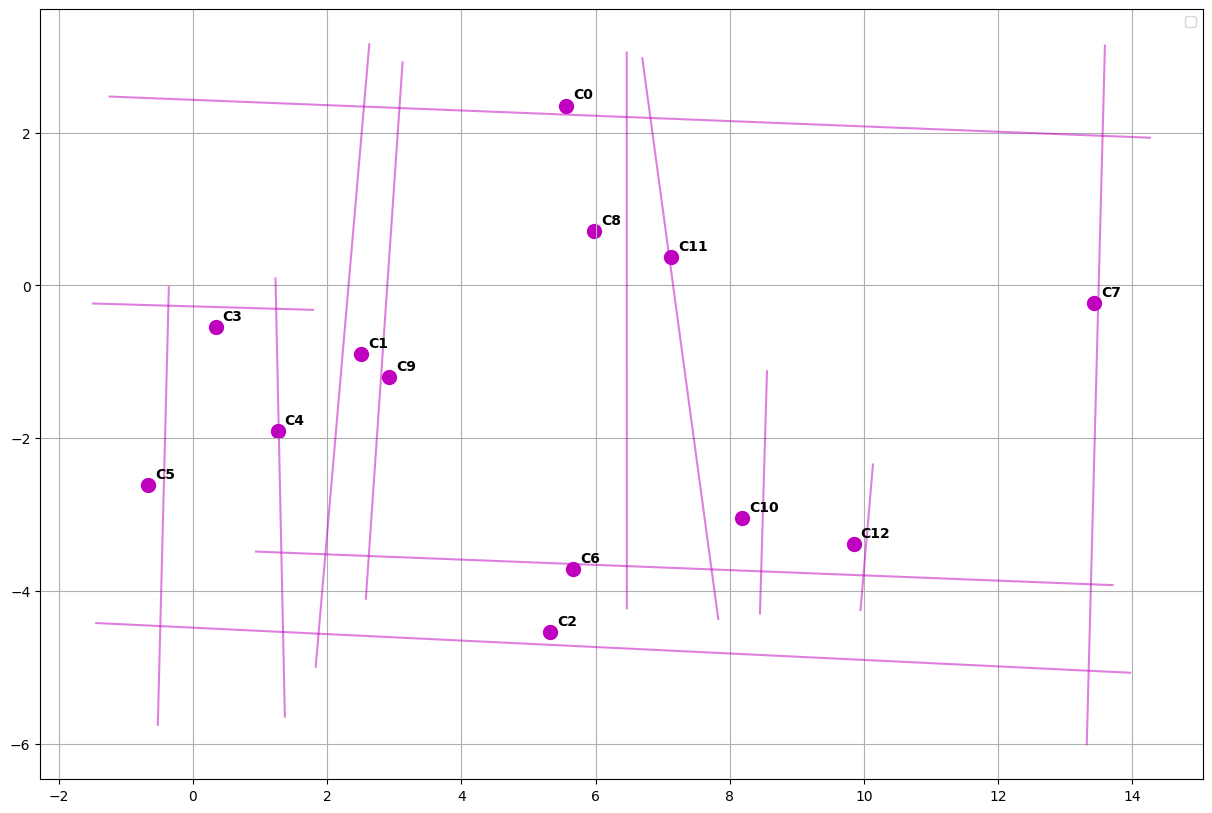

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot landmarks and their uncertainties
for landmark_id, landmark in slam_state.landmarks.items():
    line_params = slam_state.state[landmark['state_index']:landmark['state_index'] + 2]
    alpha = line_params[0, 0]
    r = line_params[1, 0]
    # get the cluster info
    cluster_id = landmark_id
    cluster_size = slam_state.clusters_size[cluster_id]
    cluster_centroid = slam_state.clusters_centroid[cluster_id]
    cluster_xlims = slam_state.clusters_xlims[cluster_id]
    cluster_ylims = slam_state.clusters_ylims[cluster_id]

    x, y = get_line_points_from_hesse(alpha, r, xlim=(cluster_xlims[0] - 0.5, cluster_xlims[1] + 0.5), ylim=(cluster_ylims[0] - 0.5, cluster_ylims[1] + 0.5))

    if x is not None and y is not None:
      ax.plot(x, y, color='m', alpha=0.5)

    # draw the centroid of the cluster
    ax.scatter(cluster_centroid[0], cluster_centroid[1], c='m', s=100)
    # draw small text near cluster with the landmark id
    ax.annotate(f'C{cluster_id}', (cluster_centroid[0], cluster_centroid[1]),
                xytext=(5, 5), textcoords='offset points',
                color='black', fontweight='bold')

plt.legend()
plt.grid()
plt.show()
plt.close(fig)

### **Estimated Trajectory: Odometry vs. line-based SLAM**

#### **Odometry Estimation**

*   Relies solely on robot motion sensors (e.g., wheel encoders, IMU).
*   Integrates sensor readings over time to estimate position and orientation.
*   Prone to cumulative errors: Small errors in each sensor reading accumulate over time, leading to significant drift in the estimated trajectory.
*   Limited accuracy, especially in long-term operation.

#### **SLAM Estimation**

*   Combines odometry with lidar environmental perception.
*   Builds a map of the environment while simultaneously localizing itself within that map.
*   Uses landmarks or features in the environment to correct odometry errors.
*   Provides more accurate and robust localization, especially over longer distances.

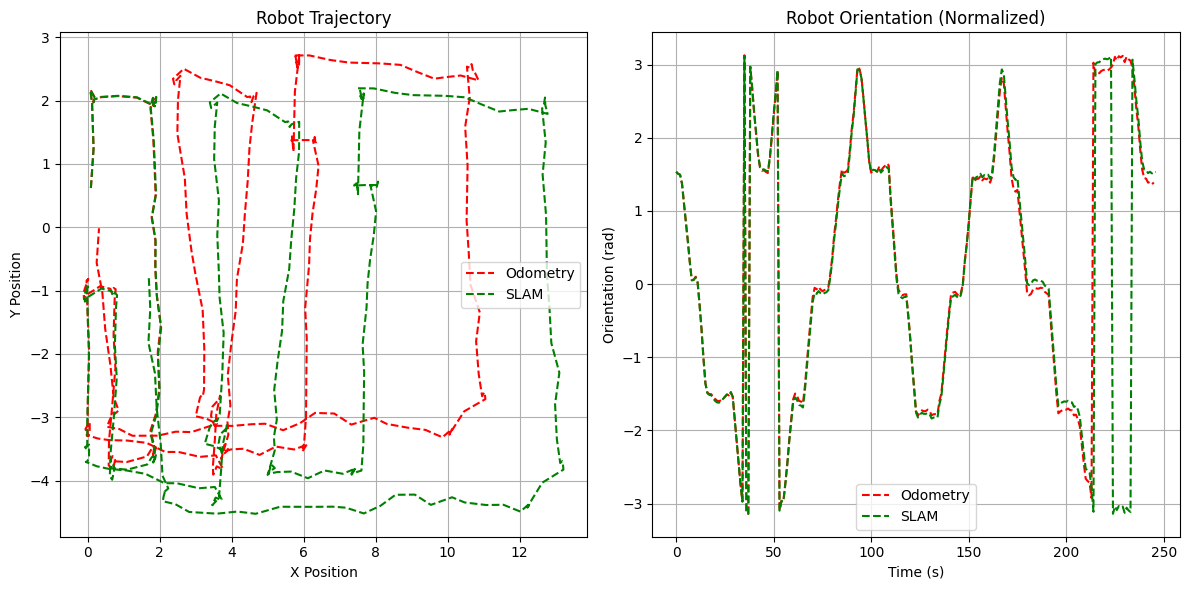

In [ ]:
import matplotlib.pyplot as plt

estimated_pos = []  # Store estimated positions
theta_est_normalized = []  # Store normalized orientation angles

for i in range(1, len(data)):
    # Compute new estimates
    robot_pos = estimated_odo_pos(data, i)
    # Normalize theta
    robot_pos[2] = normalize_angle(robot_pos[2])

    # Append to the result lists
    estimated_pos.append(robot_pos)
    theta_est_normalized.append(robot_pos[2])

# Odo estimation
x_est = [pos[0] for pos in estimated_pos]
y_est = [pos[1] for pos in estimated_pos]

# SLAM estimation
x_slam = [pos[0] for pos in corrected_poses]
y_slam = [pos[1] for pos in corrected_poses]
theta_slam_normalized = [normalize_angle(pos[2]) for pos in corrected_poses]

# Configure plot
plt.figure(figsize=(12, 6))

# Plot robot trajectory
plt.subplot(1, 2, 1)
plt.plot(x_est, y_est, label='Odometry', linestyle='--', color='red')
plt.plot(x_slam, y_slam, label='SLAM', linestyle='--', color='green')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Robot Trajectory')
plt.legend()
plt.grid(True)

# Plot robot orientation
plt.subplot(1, 2, 2)
plt.plot(theta_est_normalized, label='Odometry', linestyle='--', color='red')
plt.plot(theta_slam_normalized, label='SLAM', linestyle='--', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('Robot Orientation (Normalized)')
plt.legend()
plt.grid(True)

# Improve readability and avoid repetition
plt.tight_layout()
plt.show()

# **Final Conclusions**

## **Corner-based SLAM vs Line-based SLAM**

SLAM algorithms can rely on different feature types for localization and mapping. Two common approaches are:  

- **Corner-based SLAM:** Detects and tracks corners in the environment as distinctive landmarks. Corners provide strong, unique features for image matching.  
- **Line-based SLAM:** Detects and tracks lines, such as edges of walls, doors, and furniture. Lines tend to be more robust against noise and changes in viewpoint compared to corners.  

### **Performance in This Case**  

In this specific scenario, both corner-based and line-based SLAM approaches failed to yield satisfactory results. This failure is primarily attributed to **an inaccurate odometry model**, which significantly affected the algorithms' performance.  

However, it is worth noting that **line-based SLAM typically detects more features per step** because lines are easier to perceive in the environment compared to corners. This can provide a richer dataset for mapping and localization when odometry errors are minimized.  

### **Challenges Identified**  

1. **Odometry Inaccuracies:**  
   - Large step sizes (60 cm) and sharp turns (25 degrees) caused substantial errors in position estimation.  
   - These errors overwhelmed the SLAM algorithms, making it difficult to correct the robot's pose effectively.  

2. **Slow Control Cycle:**  
   - The current control cycle was too slow to react to rapid movements and sudden turns.  
   - This delayed response exacerbated the impact of odometry errors on the SLAM process.  

3. **Feature Utilization:**  
   - While line-based SLAM has the advantage of detecting more features per step, these additional features could not fully compensate for the odometry-related inaccuracies.  

### **Recommendations for Improvement**  

1. **Enhance the Odometry Model:**  
   - Calibrate sensors and refine motion models.  
   - Incorporate additional sensors, such as Inertial Measurement Units (IMUs), for improved motion estimation.  

2. **Adopt Smaller Movements:**  
   - Use smaller, incremental step sizes and turns to minimize the effect of odometry errors.  

3. **Increase Control Cycle Frequency:**  
   - A faster control cycle would enable quicker adjustments, improving the system’s responsiveness.  

4. **Explore Alternative SLAM Approaches:**  
   - Investigate more robust SLAM methods that are less sensitive to odometry errors, such as particle **filter-based** or **graph optimization-based** algorithms.  

### **Conclusion**  

By addressing these challenges, the system’s accuracy and robustness can be significantly enhanced. These improvements will enable the SLAM algorithms to perform more effectively.
